# Predicting Optimal Communication Channel Preferences for Banking Customers

---

**Problem Statement**  
We need to build a machine learning system that predicts the optimal communication channel preference order for each banking customer, ranking channels from most to least effective based on their historical response patterns, demographic characteristics, and engagement behavior. The model should analyze factors like past channel success rates, customer digital savviness, demographic profiles, and interaction history to recommend the best sequence of contact channels (SMS, Email, Call, WhatsApp, IVR, Field Agent) that will maximize the likelihood of successful customer engagement and response for each individual.

---

## Notebook Overview

This notebook presents the **complete solution pipeline** for the channel ranking problem:

- **1. Data Loading & Preview:**  
  Loads the raw banking customer data, displaying key columns and basic statistics for initial exploration.

- **2. Data Cleaning & Preprocessing:**  
  Handles missing values, standardizes formats, encodes categorical variables, processes numeric features, and extracts informative attributes from dates and contact info. Ensures data is robust and suitable for modeling.

- **3. Feature Engineering Pipeline:**  
  - Constructs advanced features capturing:
    - Channel-specific response rates and historic success
    - Digital savviness scores from engagement metrics
    - Time-of-day preferences for communication
    - Customer segmentation (e.g., digital, senior, young)
    - Dominant and preferred channels per user
  - Outputs clean, model-ready features for every customer.

- **4. Label Construction:**  
  - Builds target labels indicating customer-specific optimal channel orders.
  - Encodes preferences in multiple formats:
    - Full ranked list
    - Top channel
    - Binary indicators for top-3 choices
  - Labels are extracted based on effectiveness, historic interactions, and true customer choices.

- **5. Model Training & Evaluation:**  
  - Implements and trains several models for learning-to-rank:
    - **XGBoost**
    - **LightGBM** (recommended)
    - **Random Forest**
  - Splits data into training and test groups, optimizing ranking-based metrics (NDCG).
  - Evaluates models’ performance in predicting channel orders for new/unseen customers.

- **6. Prediction & Recommendation:**  
  - Uses trained models to generate channel ranking predictions for every customer.
  - Outputs recommended contact sequence (e.g., "Email > Call > IVR ...") for each individual.
  - Batch/interactive/quick prediction modes for business use.

- **7. Model Comparison & Selection:**  
  - Compares models by accuracy (NDCG), efficiency, and scalability.
  - Justifies **LightGBM** as the final solution for production based on superior results.

- **8. Business Insights & Export:**  
  - Visualizes feature importance, sample cases, and provides clear, actionable recommendations for outreach teams.
  - Outputs and saves prediction results for reporting or next-stage deployment.

---

## Final Deliverable

This notebook delivers a **business-ready, automated ranking model** that analyzes historical data and customer attributes to recommend the best channel communication sequence for each banking customer.

**Use this notebook and the provided markdown to:**
- Demonstrate your modeling workflow
- Explain decisions to management or technical reviewers
- Guide future updates or deployments

---

> **This notebook is a complete solution—from raw data to actionable AI-driven recommendations—customized to solve the real-world banking customer engagement challenge.**


### Data Pipeline

This cell builds the main **data preprocessing pipeline** to prepare raw data for feature engineering and model training. It automates the standard cleaning, transformation, and enrichment needed for high-quality machine learning input.

**Major Steps and Components:**

- **Numeric Columns Processing:**
  - Selected columns with continuous numerical values (e.g., Age, Loan Amount, Credit Score, Tenure, etc.).
  - Applies `SimpleImputer(strategy="median")` to fill missing numeric values using the median, ensuring robust statistics.
  - Uses `StandardScaler()` to normalize all numeric columns (zero mean, unit variance) for uniformity across features.

- **Categorical Columns Processing:**
  - Selected columns with categorical values (e.g., Product Type, Payment Frequency, Channel Used, Urban/Rural Tag, Gender).
  - Applies `SimpleImputer(strategy="most_frequent")` to fill missing categories with the most popular choice.
  - Applies `OneHotEncoder(handle_unknown="ignore", sparse_output=False)` to convert categorical columns into machine-readable binary variables, increasing modeling power and interpretability.

- **Date Columns Feature Extraction:**
  - For date columns (Installment Due Date, Last Payment Date), extracts month, day of week, and year as separate features.
  - Drops the original date column after extraction, retaining only the informative components.

- **Custom Transformers:**
  - Additional processing steps for complex columns (income bands, boolean flags, phone/email validation, engagement scores, location extraction).

- **Pipeline Assembly:**
  - All steps are organized in a `Pipeline` or `ColumnTransformer`, ensuring transformations are applied in the correct sequence.
  - Executes with a single command (fit_transform), reducing manual work and mistakes.

---

**Purpose:**  
Transforms raw, messy financial/customer data into a clean, modeling-ready format by automating imputation, scaling, encoding, feature extraction, and custom enrichment steps.

**Expected Output:**  
- A processed DataFrame with all features numerically encoded, scaled, and cleaned.
- Ready for direct input to feature engineering or modeling cells.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import warnings
import re
from datetime import datetime

warnings.filterwarnings('ignore')

# Custom transformers for specific data processing tasks
class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extract features from date columns"""
    def __init__(self, date_columns):
        self.date_columns = date_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.date_columns:
            if col in X.columns:
                X[col] = pd.to_datetime(X[col], errors='coerce')
                X[f'{col}_month'] = X[col].dt.month
                X[f'{col}_dayofweek'] = X[col].dt.dayofweek
                X[f'{col}_year'] = X[col].dt.year
                # Drop original date column
                X = X.drop(columns=[col])
        return X

class IncomeBandEncoder(BaseEstimator, TransformerMixin):
    """Encode income bands to numerical values"""
    def __init__(self):
        self.income_mapping = {
            '50,000 or Below': 0,
            '50,000 to 100,000': 1,
            '100,000 to 200,000': 2,
            '200,000 to 300,000': 3,
            '300,000 to 500,000': 4,
            '500,000 or Above': 5
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if 'Income_Band_SGD' in X.columns:
            X['Income_Band_SGD'] = X['Income_Band_SGD'].map(self.income_mapping)
        return X

class BooleanConverter(BaseEstimator, TransformerMixin):
    """Convert various boolean representations to proper booleans"""
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        bool_columns = ['Partial_Payment_Indicator', 'Repayment_Irregularity_Flags',
                       'Mobile_Number_Active_Status', 'Email_Activity', 'Do_Not_Call_Registry_Data']

        for col in bool_columns:
            if col in X.columns:
                X[col] = X[col].astype(str).str.lower().replace({
                    'true': True, 'false': False, '1': True, '0': False,
                    'yes': True, 'no': False
                }).astype(bool)
        return X

class DigitalEngagementCalculator(BaseEstimator, TransformerMixin):
    """Calculate digital engagement score"""
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        engagement_metrics = ['App_Login_Frequency', 'UPI_Transactions', 'Online_Banking_Activity']
        if all(metric in X.columns for metric in engagement_metrics):
            X['Digital_Engagement_Score'] = (
                X['App_Login_Frequency'] +
                X['UPI_Transactions'] +
                X['Online_Banking_Activity']
            ) / 3
        return X

class AddressProcessor(BaseEstimator, TransformerMixin):
    """Extract city and pincode from address column"""
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if 'Address' in X.columns:
            # Extract city name (usually the last word before "Singapore")
            X['City'] = X['Address'].apply(self._extract_city)

            # Extract pincode (6-digit number typically found in Singapore addresses)
            X['Pincode'] = X['Address'].apply(self._extract_pincode)

            # Drop original address column
            X = X.drop(columns=['Address'])

        return X

    def _extract_city(self, address):
        """Extract city name from address"""
        if pd.isna(address):
            return None

        # Common Singapore regions/districts
        singapore_regions = [
            'Tengah', 'Loyang', 'Pasir Ris', 'Tampines', 'Clementi', 'Jurong',
            'Queenstown', 'Woodlands', 'Serangoon', 'Bedok', 'Ang Mo Kio',
            'Toa Payoh', 'Bishan', 'Bukit Merah', 'Bukit Timah', 'Geylang',
            'Kallang', 'Marine Parade', 'Novena', 'Potong Pasir', 'Punggol',
            'Sembawang', 'Sengkang', 'Hougang', 'Yishun', 'Lim Chu Kang',
            'Mandai', 'Sungei Kadut', 'Central Area', 'Downtown Core',
            'Newton', 'Orchard', 'River Valley', 'Rochor', 'Singapore River',
            'Southern Islands', 'Straits View', 'Outram', 'Museum',
            'Dhoby Ghaut', 'Marina South', 'Marina East', 'Marina Centre'
        ]

        # Look for region names in the address
        address_lower = address.lower()
        for region in singapore_regions:
            if region.lower() in address_lower:
                return region

        # Fallback: extract the word before the first occurrence of "Singapore"
        match = re.search(r'(\w+)\s+Singapore', address, re.IGNORECASE)
        if match:
            return match.group(1)

        return 'Unknown'

    def _extract_pincode(self, address):
        """Extract 6-digit Singapore pincode from address"""
        if pd.isna(address):
            return None

        # Singapore pincodes are typically 6 digits
        pincode_pattern = r'\b(\d{6})\b'
        match = re.search(pincode_pattern, address)

        if match:
            return match.group(1)

        return None

class PhoneNumberProcessor(BaseEstimator, TransformerMixin):
    """Process and validate Singapore phone numbers"""
    def __init__(self):
        self.singapore_country_codes = ['+65', '65', '0065']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        phone_columns = ['Primary_Phone_Number', 'Secondary_Mobile_Number', 'Landline_Phone_Number']

        for col in phone_columns:
            if col in X.columns:
                # Remove country code and validate
                X[col] = X[col].apply(self._process_phone_number)
                # Add validation flag
                X[f'{col}_Valid'] = X[col].apply(self._validate_singapore_number)

        return X

    def _process_phone_number(self, phone):
        """Remove country code and clean phone number"""
        if pd.isna(phone) or not isinstance(phone, str):
            return None

        # Remove spaces, hyphens, parentheses
        cleaned = re.sub(r'[\s\-\(\)]', '', str(phone))

        # Remove Singapore country codes
        for country_code in self.singapore_country_codes:
            if cleaned.startswith(country_code):
                cleaned = cleaned[len(country_code):]
                break

        return cleaned

    def _validate_singapore_number(self, phone):
        """Validate Singapore phone number format"""
        if pd.isna(phone) or not isinstance(phone, str):
            return False

        # Singapore numbers should be 8 digits starting with 3, 6, 8, or 9
        if re.match(r'^[3689]\d{7}$', phone):
            return True

        return False

class EmailValidator(BaseEstimator, TransformerMixin):
    """Validate email addresses and extract domain information"""
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if 'Email_ID' in X.columns:
            # Validate email format
            X['Email_Valid_Format'] = X['Email_ID'].apply(self._validate_email_format)

            # Extract domain
            X['Email_Domain'] = X['Email_ID'].apply(self._extract_domain)

            # Check if domain is legitimate (common email providers)
            X['Email_Domain_Legitimate'] = X['Email_Domain'].apply(self._is_legitimate_domain)

            # Check for disposable email domains
            X['Email_Disposable'] = X['Email_Domain'].apply(self._is_disposable_domain)

        return X

    def _validate_email_format(self, email):
        """Validate basic email format"""
        if pd.isna(email) or not isinstance(email, str):
            return False

        email_pattern = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
        return bool(re.match(email_pattern, email))

    def _extract_domain(self, email):
        """Extract domain from email address"""
        if pd.isna(email) or not isinstance(email, str) or '@' not in email:
            return None

        return email.split('@')[1].lower()

    def _is_legitimate_domain(self, domain):
        """Check if domain is from a legitimate email provider"""
        if pd.isna(domain):
            return False

        legitimate_domains = [
            'gmail.com', 'yahoo.com', 'hotmail.com', 'outlook.com', 'live.com',
            'icloud.com', 'protonmail.com', 'zoho.com', 'aol.com', 'mail.com',
            'gmail.com.sg', 'yahoo.com.sg', 'hotmail.com.sg', 'singnet.com.sg',
            'starhub.net.sg', 'pacific.net.sg'
        ]

        return domain in legitimate_domains

    def _is_disposable_domain(self, domain):
        """Check if domain is from a disposable email service"""
        if pd.isna(domain):
            return False

        disposable_domains = [
            'tempmail.com', '10minutemail.com', 'guerrillamail.com',
            'mailinator.com', 'yopmail.com', 'trashmail.com',
            'disposableemail.com', 'fakeinbox.com', 'temp-mail.org'
        ]

        return domain in disposable_domains

class DataLoader(BaseEstimator, TransformerMixin):
    """Load and initial data processing"""
    def __init__(self, file_path, chunk_size=10000):
        self.file_path = file_path
        self.chunk_size = chunk_size

    def fit(self, X, y=None):
        return self

    def transform(self, X=None):
        """Load data from CSV file"""
        print("Loading data...")

        try:
            # Load data in chunks for memory efficiency
            chunks = []
            for i, chunk in enumerate(pd.read_csv(self.file_path, chunksize=self.chunk_size)):
                chunks.append(chunk)
                if (i + 1) % 10 == 0:  # Print progress every 10 chunks
                    print(f"Loaded {min((i+1)*self.chunk_size, self._get_total_rows()):,} rows")

            df = pd.concat(chunks, ignore_index=True)
            print(f"Successfully loaded {len(df):,} rows")
            return df
        except Exception as e:
            print(f"Error loading data: {e}")
            # Return empty DataFrame with expected structure
            return pd.DataFrame()

    def _get_total_rows(self):
        """Get total number of rows in the file"""
        try:
            return sum(1 for line in open(self.file_path)) - 1  # Subtract header
        except:
            return 0

class SklearnDataPipeline:
    def __init__(self, file_path):
        self.file_path = file_path
        self.pipeline = None
        self.processed_data = None
        self.column_names = None
        self._build_pipeline()

    def _get_numeric_columns(self):
        """Define numeric columns for preprocessing"""
        return ['Age', 'Loan_Amount_SGD', 'Outstanding_Balance_SGD', 'Day_Past_Due',
                'Tenure', 'Interest_Rate', 'Current_EMI_SGD', 'Number_of_Past_Payments',
                'Amount_Paid_Each_Month_SGD', 'Bounce_History', 'Contact_History_Call_Attempts',
                'Contact_History_SMS', 'Contact_History_WhatsApp', 'Contact_History_EmailLogs',
                'No_of_Attempts', 'Average_Handling_Time', 'Credit_Score', 'Recent_Inquiries',
                'Loan_Exposure_Across_Banks', 'Recent_Score_Change', 'Unemployeement_rate_region',
                'Inflation_Rate', 'Interest_Rate_Trend', 'Economic_Stress_Index',
                'Income_Band_SGD', 'Digital_Engagement_Score']

    def _get_categorical_columns(self):
        """Define categorical columns for preprocessing"""
        return ['Product_Type', 'Payment_Frequency', 'Settlement_History',
                'Channel_used', 'Response_Outcome', 'Urban_Rural_Tag',
                'Language_Preference', 'Smartphone_Penetration', 'Preferred_Channel',
                'Call_SMS_Activity_Patterns', 'WhatsApp_OTT_usage_Indicator',
                'Regional_Time_Restrictions', 'Communication_Complaince_Limits',
                'Gender', 'Occupation', 'Employeement_Type']

    def _get_date_columns(self):
        """Define date columns for processing"""
        return ['Installment_Due_Date', 'Last_Payment_Date']

    def _get_passthrough_columns(self, df):
        """Get columns that are not processed by numeric or categorical transformers"""
        if df is None:
            return []

        all_columns = set(df.columns)
        processed_columns = set(self._get_numeric_columns() + self._get_categorical_columns())
        passthrough_columns = list(all_columns - processed_columns)

        return passthrough_columns

    def _build_pipeline(self):
        """Build the scikit-learn pipeline"""

        # Define column transformers for different data types
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        # Main preprocessing pipeline
        self.pipeline = Pipeline([
            # Step 1: Load data
            ('data_loader', DataLoader(self.file_path)),

            # Step 2: Process address information
            ('address_processor', AddressProcessor()),

            # Step 3: Process phone numbers
            ('phone_processor', PhoneNumberProcessor()),

            # Step 4: Validate email addresses
            ('email_validator', EmailValidator()),

            # Step 5: Convert boolean columns
            ('boolean_converter', BooleanConverter()),

            # Step 6: Encode income bands
            ('income_encoder', IncomeBandEncoder()),

            # Step 7: Extract date features
            ('date_extractor', DateFeatureExtractor(self._get_date_columns())),

            # Step 8: Calculate digital engagement
            ('engagement_calculator', DigitalEngagementCalculator()),
        ])

    def _get_all_feature_names(self, df):
        """Get all feature names after preprocessing"""
        # Get numeric features
        numeric_features = self._get_numeric_columns()

        # Get categorical feature names (after one-hot encoding)
        categorical_features = []
        for col in self._get_categorical_columns():
            if col in df.columns:
                unique_vals = df[col].dropna().unique()
                for val in unique_vals:
                    categorical_features.append(f"{col}_{val}")

        # Get passthrough features
        passthrough_features = self._get_passthrough_columns(df)

        # Combine all feature names
        all_features = numeric_features + categorical_features + passthrough_features

        return all_features

    def fit_transform(self, save_path=None):
        """Run the complete pipeline and return processed data"""
        print("=" * 50)
        print("RUNNING SKLEARN DATA PIPELINE")
        print("=" * 50)

        try:
            # Run the pipeline steps manually to maintain DataFrame structure
            df = self.pipeline.named_steps['data_loader'].transform(None)
            original_shape = df.shape

            print("Applying preprocessing steps...")
            for step_name, transformer in list(self.pipeline.named_steps.items())[1:]:
                print(f"Applying {step_name}...")
                df = transformer.fit_transform(df)

            # Remove duplicates
            df = df.drop_duplicates()

            # Apply standard preprocessing to numeric and categorical columns
            numeric_features = [col for col in self._get_numeric_columns() if col in df.columns]
            categorical_features = [col for col in self._get_categorical_columns() if col in df.columns]

            # Handle numeric columns
            numeric_imputer = SimpleImputer(strategy='median')
            numeric_scaler = StandardScaler()

            if numeric_features:
                df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])
                df[numeric_features] = numeric_scaler.fit_transform(df[numeric_features])

            # Handle categorical columns
            if categorical_features:
                categorical_imputer = SimpleImputer(strategy='most_frequent')
                onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

                # Impute missing values
                df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

                # One-hot encode categorical variables
                encoded_array = onehot_encoder.fit_transform(df[categorical_features])
                encoded_columns = onehot_encoder.get_feature_names_out(categorical_features)

                # Create DataFrame for encoded features
                encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=df.index)

                # Drop original categorical columns and add encoded ones
                df = df.drop(columns=categorical_features)
                df = pd.concat([df, encoded_df], axis=1)

            self.processed_data = df.reset_index(drop=True)

            # Save if path provided
            if save_path:
                self.save_processed_data(save_path)

            print("Pipeline completed successfully!")
            print(f"Original shape: {original_shape}")
            print(f"Processed shape: {self.processed_data.shape}")

            return self.processed_data

        except Exception as e:
            print(f"Error in pipeline: {e}")
            import traceback
            traceback.print_exc()
            return None

    def save_processed_data(self, path):
        """Save the processed data"""
        if self.processed_data is not None:
            self.processed_data.to_csv(path, index=False)
            print(f"Processed data saved to {path}")

            # Also save the pipeline for future use
            joblib.dump(self.pipeline, 'data_pipeline.pkl')
            print("Pipeline saved as 'data_pipeline.pkl'")

    def load_and_transform_new_data(self, new_data_path):
        """Load and transform new data using the fitted pipeline"""
        if self.pipeline is None:
            raise ValueError("Pipeline not fitted yet. Call fit_transform first.")

        # Load new data
        new_data_loader = DataLoader(new_data_path)
        new_df = new_data_loader.transform(None)

        # Apply the same transformations
        for step_name, transformer in list(self.pipeline.named_steps.items())[1:]:
            new_df = transformer.transform(new_df)

        return new_df

# Example usage
if __name__ == "__main__":
    # Initialize the sklearn pipeline
    sklearn_pipeline = SklearnDataPipeline('singapore_loan_data.csv')

    # Run the complete pipeline
    processed_data = sklearn_pipeline.fit_transform(save_path='processed_data.csv')

    if processed_data is not None:
        # Display results
        print("\nPipeline Summary:")
        print(f"Processed data shape: {processed_data.shape}")
        print(f"Processed data columns: {len(processed_data.columns)}")

        print("\nSample of processed data:")
        print(processed_data.head())

        print("\nData types after processing:")
        print(processed_data.dtypes.value_counts())

        # Show the new columns created by the data cleaning processes
        new_columns = ['City', 'Pincode', 'Email_Valid_Format', 'Email_Domain',
                       'Email_Domain_Legitimate', 'Email_Disposable']

        print("\nNew columns created by data cleaning:")
        for col in new_columns:
            if col in processed_data.columns:
                print(f"{col}: {processed_data[col].notna().sum()} non-null values")

        # Show phone number validation results
        phone_columns = ['Primary_Phone_Number', 'Secondary_Mobile_Number', 'Landline_Phone_Number']
        for col in phone_columns:
            valid_col = f'{col}_Valid'
            if valid_col in processed_data.columns:
                valid_count = processed_data[valid_col].sum()
                total_count = processed_data[valid_col].count()
                print(f"{valid_col}: {valid_count}/{total_count} valid numbers")
    else:
        print("Pipeline failed to process data.")

RUNNING SKLEARN DATA PIPELINE
Loading data...
Loaded 100,000 rows
Successfully loaded 100,000 rows
Applying preprocessing steps...
Applying address_processor...
Applying phone_processor...
Applying email_validator...
Applying boolean_converter...
Applying income_encoder...
Applying date_extractor...
Applying engagement_calculator...
Processed data saved to processed_data.csv
Pipeline saved as 'data_pipeline.pkl'
Pipeline completed successfully!
Original shape: (100000, 60)
Processed shape: (100000, 121)

Pipeline Summary:
Processed data shape: (100000, 121)
Processed data columns: 121

Sample of processed data:
    Customer_id  Loan_Account_id  Loan_Amount_SGD  Outstanding_Balance_SGD  \
0  SCB251079598         62286002        -0.726394                -0.424012   
1  SCB190053374         36063245         1.542636                -0.309076   
2  SCB949472217         82586911        -0.154525                -0.505886   
3  SCB502330059         47856186         0.574147                 0.7

### Feature Pipeline

This cell builds the main **feature engineering pipeline** for channel preference prediction. The pipeline systematically processes the raw data into a new DataFrame of engineered features that are ready to be used by machine learning models.

**Pipeline Steps:**

1. **CustomerIdPreserver:**  
   - Ensures the `Customer_id` column is preserved throughout the pipeline, so every row can be traced back to the customer.

2. **ChannelResponseCalculator:**  
   - Calculates new response rate features for each communication channel (Call, SMS, Email, WhatsApp, IVR, Field Agent).
   - For each channel, it computes the ratio of positive outcomes to total uses, indicating which channels work best for each customer.

3. **DigitalSavvinessCalculator:**  
   - Creates a digital savviness score by combining digital engagement metrics (such as app logins, online banking activity, UPI transactions).
   - Normalizes and blends these scores to summarize how comfortable each customer is with digital channels.

4. **TimePreferenceCalculator:**  
   - Encodes each customer’s communication time preference (morning, afternoon, evening, night) as a single numeric feature.
   - This helps the model to recommend channels likely to be most effective at the customer’s preferred times.

5. **ChannelSuccessHistoryCalculator:**  
   - Normalizes and encodes the historical usage of different channels for each customer.
   - Shows how often each channel has been successfully used in the past.

6. **CustomerSegmentCreator:**  
   - Assigns customers to segments (such as 'High_Value_Digital', 'Traditional', 'Young', 'Senior', or 'Standard') based on demographic and behavioral features.
   - Segmentation helps the models treat different customer groups distinctly.

7. **PreferredChannelFeatureEngineer:**  
   - Creates features indicating which communication channels are preferred by the customer (e.g., preferred_call, preferred_email, etc.).
   - Counts the total number of preferred channels and extracts the dominant (most-used) channel.

8. **FeatureSelector:**  
   - Finally, selects a specified list of engineered features (including `Customer_id` and all the important columns created above) for modeling.
   - This reduces dimensionality and ensures only meaningful features are passed onward.

---

**Purpose:**  
This pipeline automates the entire feature engineering flow—cleaning, transforming, and enriching raw data to maximize predictive signal for channel ranking models. Each step builds features specific to customer communication behavior, response history, and digital usage, which are critical for accurate channel preference prediction.

**Expected Output:**  
A new DataFrame containing all selected engineered features, with `Customer_id` preserved, and one row for each customer, ready for use in model training and evaluation.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import joblib

warnings.filterwarnings('ignore')

class ChannelResponseCalculator(BaseEstimator, TransformerMixin):
    """Calculate response metrics for each communication channel"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Define positive response outcomes
        positive_responses = [
            'Response_Outcome_Connected',
            'Response_Outcome_Paid fully',
            'Response_Outcome_Partial paid',
            'Response_Outcome_Promised to pay'
        ]

        # Calculate response rate per channel
        channel_columns = {
            'SMS': 'Channel_used_SMS',
            'Email': 'Channel_used_Email',
            'Call': 'Channel_used_Call',
            'WhatsApp': 'Channel_used_WhatsApp',
            'IVR': 'Channel_used_IVR',
            'Field_Agent': 'Channel_used_Field Agent'
        }

        # Channel usage frequency (historical)
        for channel, col in channel_columns.items():
            if col in X.columns:
                # Response rate for this channel
                response_col = f'Channel_{channel}_Response_Rate'
                X[response_col] = 0.0

                # If channel was used, check if it led to positive response
                channel_used_mask = X[col] == 1
                if channel_used_mask.any():
                    # Calculate positive response rate for this channel
                    positive_mask = X[positive_responses].any(axis=1)
                    successful_uses = (channel_used_mask & positive_mask).sum()
                    total_uses = channel_used_mask.sum()

                    if total_uses > 0:
                        response_rate = successful_uses / total_uses
                        X.loc[channel_used_mask, response_col] = response_rate

                # Channel usage frequency (normalized)
                usage_freq_col = f'Channel_{channel}_Usage_Frequency'
                X[usage_freq_col] = X[col]  # Binary usage indicator

        return X

class DigitalSavvinessCalculator(BaseEstimator, TransformerMixin):
    """Calculate digital savviness score based on digital engagement metrics"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Digital engagement metrics
        digital_metrics = [
            'App_Login_Frequency', 'UPI_Transactions', 'Online_Banking_Activity',
            'WhatsApp_OTT_usage_Indicator_True', 'Smartphone_Penetration_High'
        ]

        available_metrics = [metric for metric in digital_metrics if metric in X.columns]

        if available_metrics:
            # Normalize and combine digital metrics
            digital_scores = []

            for metric in available_metrics:
                if X[metric].dtype in [np.int64, np.float64]:
                    # Normalize numerical metrics
                    normalized = (X[metric] - X[metric].min()) / (X[metric].max() - X[metric].min() + 1e-8)
                    digital_scores.append(normalized)
                else:
                    # For binary metrics, use as-is
                    digital_scores.append(X[metric].astype(float))

            if digital_scores:
                X['Digital_Savviness_Score'] = pd.concat(digital_scores, axis=1).mean(axis=1)

        return X

class TimePreferenceCalculator(BaseEstimator, TransformerMixin):
    """Calculate customer time preferences for communication"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Time restriction preferences
        time_columns = [
            'Regional_Time_Restrictions_Morning',
            'Regional_Time_Restrictions_Afternoon',
            'Regional_Time_Restrictions_Evening',
            'Regional_Time_Restrictions_Night'
        ]

        available_time_cols = [col for col in time_columns if col in X.columns]

        if available_time_cols:
            # Create time preference vector
            time_preference = X[available_time_cols].idxmax(axis=1)

            # Encode time preferences
            time_mapping = {
                'Regional_Time_Restrictions_Morning': 0,
                'Regional_Time_Restrictions_Afternoon': 1,
                'Regional_Time_Restrictions_Evening': 2,
                'Regional_Time_Restrictions_Night': 3
            }

            X['Time_Preference_Encoded'] = time_preference.map(time_mapping).fillna(0)

        return X

class ChannelSuccessHistoryCalculator(BaseEstimator, TransformerMixin):
    """Calculate historical success metrics for each channel"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Historical contact metrics
        contact_columns = {
            'Call': 'Contact_History_Call_Attempts',
            'SMS': 'Contact_History_SMS',
            'WhatsApp': 'Contact_History_WhatsApp',
            'Email': 'Contact_History_EmailLogs'
        }

        for channel, col in contact_columns.items():
            if col in X.columns:
                # Normalize contact frequency
                if X[col].max() > 0:
                    X[f'Historical_{channel}_Contact_Frequency'] = (
                        X[col] / X[col].max()
                    )
                else:
                    X[f'Historical_{channel}_Contact_Frequency'] = 0

        return X

class CustomerSegmentCreator(BaseEstimator, TransformerMixin):
    """Create customer segments based on demographics and behavior"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Create customer segments
        conditions = [
            # High-value digital-savvy customers
            (X.get('Income_Band_SGD', 0) > 0.5) & (X.get('Digital_Savviness_Score', 0) > 0.6),

            # Traditional customers (low digital engagement)
            (X.get('Digital_Savviness_Score', 0) < 0.3),

            # Young customers (assuming Age is normalized)
            (X.get('Age', 0) < -0.5),

            # Senior customers
            (X.get('Age', 0) > 0.5)
        ]

        segments = ['High_Value_Digital', 'Traditional', 'Young', 'Senior']

        X['Customer_Segment'] = 'Standard'
        for condition, segment in zip(conditions, segments):
            if isinstance(condition, pd.Series):
                X.loc[condition, 'Customer_Segment'] = segment

        return X

class PreferredChannelFeatureEngineer(BaseEstimator, TransformerMixin):
    """Engineer features related to channel preferences"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Preferred channel features
        preferred_channels = [
            'Preferred_Channel_Call', 'Preferred_Channel_Email',
            'Preferred_Channel_SMS', 'Preferred_Channel_WhatsApp',
            'Preferred_Channel_IVR', 'Preferred_Channel_Field Agent',
            'Preferred_Channel_App notification'
        ]

        available_pref_channels = [col for col in preferred_channels if col in X.columns]

        if available_pref_channels:
            # Dominant preferred channel
            X['Dominant_Preferred_Channel'] = X[available_pref_channels].idxmax(axis=1)
            X['Number_of_Preferred_Channels'] = X[available_pref_channels].sum(axis=1)

        return X

class FeatureSelector(BaseEstimator, TransformerMixin):
    """Select final features for the channel preference model"""

    def __init__(self, feature_list=None):
        self.feature_list = feature_list

    def fit(self, X, y=None):
        if self.feature_list is None:
            # Define default feature list
            self.feature_list = [
                # Identifier column (MUST KEEP)
                'Customer_id',

                # Demographic features
                'Age', 'Income_Band_SGD', 'Urban_Rural_Tag_Urban',
                'Language_Preference_English', 'Language_Preference_Regional',

                # Digital engagement
                'Digital_Savviness_Score', 'App_Login_Frequency',
                'Online_Banking_Activity', 'Smartphone_Penetration_High',

                # Channel response rates
                'Channel_SMS_Response_Rate', 'Channel_Email_Response_Rate',
                'Channel_Call_Response_Rate', 'Channel_WhatsApp_Response_Rate',
                'Channel_IVR_Response_Rate', 'Channel_Field_Agent_Response_Rate',

                # Historical usage
                'Historical_Call_Contact_Frequency', 'Historical_SMS_Contact_Frequency',
                'Historical_WhatsApp_Contact_Frequency', 'Historical_Email_Contact_Frequency',

                # Time preferences
                'Time_Preference_Encoded',

                # Customer segment
                'Customer_Segment',

                # Loan characteristics
                'Loan_Amount_SGD', 'Outstanding_Balance_SGD', 'Day_Past_Due',
                'Credit_Score', 'Tenure'
            ]
        return self

    def transform(self, X):
        # Select only the features that exist in X
        available_features = [f for f in self.feature_list if f in X.columns]

        # Ensure Customer_id is always included if it exists
        if 'Customer_id' in X.columns and 'Customer_id' not in available_features:
            available_features = ['Customer_id'] + available_features

        return X[available_features]

class CustomerIdPreserver(BaseEstimator, TransformerMixin):
    """Preserve Customer_id throughout the pipeline"""

    def __init__(self):
        self.customer_id_col = 'Customer_id'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Store Customer_id separately if it exists
        if self.customer_id_col in X.columns:
            self.customer_ids_ = X[self.customer_id_col].copy()
        else:
            self.customer_ids_ = None

        return X

class ChannelPreferenceFeaturePipeline:
    """Main feature pipeline for channel preference prediction"""

    def __init__(self):
        self.pipeline = None
        self.feature_names = None
        self._build_pipeline()

    def _build_pipeline(self):
        """Build the feature engineering pipeline"""

        self.pipeline = Pipeline([
            # Step 0: Preserve Customer_id
            ('id_preserver', CustomerIdPreserver()),

            # Step 1: Calculate channel response metrics
            ('channel_response_calculator', ChannelResponseCalculator()),

            # Step 2: Calculate digital savviness
            ('digital_savviness_calculator', DigitalSavvinessCalculator()),

            # Step 3: Calculate time preferences
            ('time_preference_calculator', TimePreferenceCalculator()),

            # Step 4: Calculate channel success history
            ('channel_success_history', ChannelSuccessHistoryCalculator()),

            # Step 5: Create customer segments
            ('customer_segment_creator', CustomerSegmentCreator()),

            # Step 6: Engineer preferred channel features
            ('preferred_channel_engineer', PreferredChannelFeatureEngineer()),

            # Step 7: Final feature selection (includes Customer_id)
            ('feature_selector', FeatureSelector())
        ])

    def fit_transform(self, X, y=None):
        """Fit and transform the data"""
        print("=" * 50)
        print("RUNNING CHANNEL PREFERENCE FEATURE PIPELINE")
        print("=" * 50)

        try:
            # Store original Customer_id if it exists
            if 'Customer_id' in X.columns:
                original_customer_ids = X['Customer_id'].copy()
            else:
                original_customer_ids = None

            # Transform the data
            X_transformed = self.pipeline.fit_transform(X)

            # Ensure Customer_id is preserved in the final output
            if original_customer_ids is not None and 'Customer_id' not in X_transformed.columns:
                X_transformed['Customer_id'] = original_customer_ids.values

            # Move Customer_id to the first column if it exists
            if 'Customer_id' in X_transformed.columns:
                cols = ['Customer_id'] + [col for col in X_transformed.columns if col != 'Customer_id']
                X_transformed = X_transformed[cols]

            # Get feature names
            self.feature_names = list(X_transformed.columns)

            print(f"Feature engineering completed!")
            print(f"Original shape: {X.shape}")
            print(f"Transformed shape: {X_transformed.shape}")
            print(f"Number of features: {len(self.feature_names)}")

            # Check if Customer_id is preserved
            if 'Customer_id' in X_transformed.columns:
                print("✅ Customer_id successfully preserved in features")
            else:
                print("❌ Customer_id was not preserved")

            return X_transformed

        except Exception as e:
            print(f"Error in feature pipeline: {e}")
            import traceback
            traceback.print_exc()
            return None

    def transform(self, X):
        """Transform new data using fitted pipeline"""
        if self.pipeline is None:
            raise ValueError("Pipeline not fitted yet. Call fit_transform first.")

        # Store original Customer_id if it exists
        if 'Customer_id' in X.columns:
            original_customer_ids = X['Customer_id'].copy()
        else:
            original_customer_ids = None

        X_transformed = self.pipeline.transform(X)

        # Ensure Customer_id is preserved
        if original_customer_ids is not None and 'Customer_id' not in X_transformed.columns:
            X_transformed['Customer_id'] = original_customer_ids.values

        # Move Customer_id to the first column if it exists
        if 'Customer_id' in X_transformed.columns:
            cols = ['Customer_id'] + [col for col in X_transformed.columns if col != 'Customer_id']
            X_transformed = X_transformed[cols]

        return X_transformed

    def get_feature_names(self):
        """Get the names of the engineered features"""
        return self.feature_names

    def get_feature_importance(self, model):
        """Get feature importance from trained model"""
        if hasattr(model, 'feature_importances_'):
            # Exclude Customer_id from feature importance calculation
            feature_names = [f for f in self.feature_names if f != 'Customer_id']
            importances = model.feature_importances_

            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            return importance_df
        else:
            print("Model does not have feature_importances_ attribute")
            return None

# Example usage with your existing data pipeline
if __name__ == "__main__":
    # Load your preprocessed data
    # Assuming you have the data from your sklearn pipeline
    # Note: Make sure your input data has 'Customer_id' column
    df = pd.read_csv('processed_data.csv')

    # Check if Customer_id exists
    if 'Customer_id' not in df.columns:
        print("❌ Warning: 'Customer_id' column not found in input data")
        print("Available columns:", df.columns.tolist()[:10])  # Show first 10 columns

        # Try to find alternative customer identifier columns
        customer_id_variants = ['Customer_id', 'Customer_ID', 'customer_id', 'CUSTOMER_ID',
                               'CustomerId', 'customerId', 'CUSTOMERID', 'Client_id', 'client_id']

        for variant in customer_id_variants:
            if variant in df.columns:
                print(f"✅ Found alternative identifier: {variant}")
                df = df.rename(columns={variant: 'Customer_id'})
                break
        else:
            # If no customer ID found, create a temporary one
            print("⚠️ No customer identifier found. Creating temporary Customer_id...")
            df['Customer_id'] = [f'CUST_{i+1:06d}' for i in range(len(df))]

    # Initialize feature pipeline
    feature_pipeline = ChannelPreferenceFeaturePipeline()

    # Run feature engineering
    features = feature_pipeline.fit_transform(df)

    if features is not None:
        print("\nEngineered Features Summary:")
        print(f"Features shape: {features.shape}")
        print(f"Feature names: {features.columns.tolist()}")

        print("\nSample of engineered features (showing Customer_id and first few columns):")
        # Show Customer_id and first 5 feature columns
        display_cols = ['Customer_id'] + [col for col in features.columns if col != 'Customer_id'][:5]
        print(features[display_cols].head())

        # Display feature statistics (excluding Customer_id)
        numeric_features = features.select_dtypes(include=[np.number]).columns
        numeric_features = [f for f in numeric_features if f != 'Customer_id']

        if len(numeric_features) > 0:
            print("\nFeature statistics (numeric features only):")
            print(features[numeric_features].describe())

        # Check for new engineered columns
        new_engineered_columns = [
            col for col in features.columns
            if any(keyword in col for keyword in [
                'Response_Rate', 'Savviness', 'Historical', 'Segment', 'Preference'
            ]) and col != 'Customer_id'
        ]

        print(f"\nNew engineered columns: {len(new_engineered_columns)}")
        for col in new_engineered_columns:
            print(f"  - {col}")

        # ✅ Save engineered features to CSV
        features.to_csv("engineered_features.csv", index=False)
        print("\n[INFO] Engineered features saved to engineered_features.csv")

        # ✅ Save the fitted pipeline using joblib
        joblib.dump(feature_pipeline, "feature_pipeline.pkl")
        print("[INFO] Feature pipeline saved to feature_pipeline.pkl")

    else:
        print("Feature pipeline failed!")

RUNNING CHANNEL PREFERENCE FEATURE PIPELINE
Feature engineering completed!
Original shape: (100000, 121)
Transformed shape: (100000, 27)
Number of features: 27
✅ Customer_id successfully preserved in features

Engineered Features Summary:
Features shape: (100000, 27)
Feature names: ['Customer_id', 'Age', 'Income_Band_SGD', 'Urban_Rural_Tag_Urban', 'Language_Preference_English', 'Language_Preference_Regional', 'Digital_Savviness_Score', 'App_Login_Frequency', 'Online_Banking_Activity', 'Smartphone_Penetration_High', 'Channel_SMS_Response_Rate', 'Channel_Email_Response_Rate', 'Channel_Call_Response_Rate', 'Channel_WhatsApp_Response_Rate', 'Channel_IVR_Response_Rate', 'Channel_Field_Agent_Response_Rate', 'Historical_Call_Contact_Frequency', 'Historical_SMS_Contact_Frequency', 'Historical_WhatsApp_Contact_Frequency', 'Historical_Email_Contact_Frequency', 'Time_Preference_Encoded', 'Customer_Segment', 'Loan_Amount_SGD', 'Outstanding_Balance_SGD', 'Day_Past_Due', 'Credit_Score', 'Tenure']

S

### Label Creation

This cell constructs the **target labels** and ranking outputs for channel preference modeling. Labels are engineered from the processed features to guide the machine learning algorithm in learning which communication channel order is optimal for each customer.

**Major Code Steps Explained:**

- **ChannelEffectivenessCalculator:**  
  - Calculates the effectiveness score for each channel (SMS, Email, Call, WhatsApp, IVR, Field Agent).
  - For each customer and channel, the code combines the channel’s recent response rate and historical usage (with bonus for frequently used channels).
  - Example:
    ```
    X[f'{channel}_Effectiveness'] = effectiveness_score
    ```
- **ChannelRanker:**  
  - Ranks all channels for each customer from most effective to least effective using the effectiveness scores.
  - Generates a string for each customer such as `"SMS,Call,Email,IVR,Field_Agent,WhatsApp"` indicating the preference order.
  - Example:
    ```
    X['Channel_Preference_Order'] = preference_orders
    ```
- **PreferenceLabelEncoder:**  
  - Converts preference order strings into unique integer labels, suitable for model training.
  - Provides additional formats:
    - **`Top_Channel`**: The highest-ranked channel for each customer.
    - Binary indicators—for each channel, a column indicating if it’s in the top-3 preferred channels.
    - Example:
      ```
      X['Preference_Label'] = label_encoder.transform(X['Channel_Preference_Order'])
      X['Top_Channel'] = X['Channel_Preference_Order'].str.split(',').str
      X[f'Prefers_{channel}_Top3'] = (channel in X['Channel_Preference_Order'].split(',')[:3])
      ```

---

**Label Columns Generated:**  
- `Customer_id`
- `Channel_Preference_Order` (comma-separated ranking, e.g. `"SMS,Call,Email,IVR,Field_Agent,WhatsApp"`)
- `Preference_Label` (categorical int, for classification tasks)
- `Top_Channel` (best channel for each customer)
- `Prefers_SMS_Top3`, `Prefers_Email_Top3`, etc. (binary columns for each channel being in the top 3)

**Purpose:**  
- **Provides multiple targets** (full ranking order, top channel, binary indicators) for advanced modeling scenarios.
- Prepares labels in all formats needed for ranking, classification, and custom loss functions.

**Expected Output:**  
A DataFrame with customer IDs and label columns, ready for supervised machine learning.  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import warnings

warnings.filterwarnings('ignore')

class ChannelEffectivenessCalculator(BaseEstimator, TransformerMixin):
    """Calculate how effective each channel is for each customer"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Define the channels we're analyzing
        channels = ['SMS', 'Email', 'Call', 'WhatsApp', 'IVR', 'Field_Agent']

        # For each channel, calculate an effectiveness score
        for channel in channels:
            # Start with response rate (most important factor)
            response_col = f'Channel_{channel}_Response_Rate'

            if response_col in X.columns:
                # Use response rate as base score
                effectiveness_score = X[response_col].fillna(0)

                # Add bonus for historical usage (more data = more reliable)
                historical_col = f'Historical_{channel}_Contact_Frequency'
                if historical_col in X.columns:
                    # Channels used more often get small bonus (0.1 max)
                    usage_bonus = X[historical_col].fillna(0) * 0.1
                    effectiveness_score = effectiveness_score + usage_bonus

                X[f'{channel}_Effectiveness'] = effectiveness_score
            else:
                # If no data, set to neutral score
                X[f'{channel}_Effectiveness'] = 0.5

        return X

class ChannelRanker(BaseEstimator, TransformerMixin):
    """Rank channels from best to worst for each customer"""

    def __init__(self):
        self.channels = ['SMS', 'Email', 'Call', 'WhatsApp', 'IVR', 'Field_Agent']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Get effectiveness scores for all channels
        effectiveness_cols = [f'{channel}_Effectiveness' for channel in self.channels]

        # For each customer, rank channels by effectiveness
        preference_orders = []

        for i in range(len(X)):
            customer_scores = {}

            # Get scores for this customer
            for channel in self.channels:
                score_col = f'{channel}_Effectiveness'
                if score_col in X.columns:
                    customer_scores[channel] = X[score_col].iloc[i]
                else:
                    customer_scores[channel] = 0  # Default if missing

            # Sort channels by score (highest to lowest)
            ranked_channels = sorted(customer_scores.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

            # Create preference order string
            preference_order = ','.join([channel for channel, score in ranked_channels])
            preference_orders.append(preference_order)

        # Add preference order to dataframe
        X['Channel_Preference_Order'] = preference_orders

        return X

class PreferenceLabelEncoder(BaseEstimator, TransformerMixin):
    """Convert preference orders into model-friendly formats"""

    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.unique_orders = None

    def fit(self, X, y=None):
        if 'Channel_Preference_Order' in X.columns:
            # Learn all possible preference patterns
            self.unique_orders = X['Channel_Preference_Order'].unique()
            self.label_encoder.fit(self.unique_orders)
        return self

    def transform(self, X):
        X = X.copy()

        if 'Channel_Preference_Order' not in X.columns:
            print("No preference orders found. Run ChannelRanker first.")
            return X

        # Method 1: Encode entire order as one label (like animal classification)
        X['Preference_Label'] = self.label_encoder.transform(X['Channel_Preference_Order'])

        # Method 2: Create simple "top choice" label
        X['Top_Channel'] = X['Channel_Preference_Order'].str.split(',').str[0]

        # Method 3: Binary indicators for each channel being in top 3
        for channel in ['SMS', 'Email', 'Call', 'WhatsApp']:
            X[f'Prefers_{channel}_Top3'] = X['Channel_Preference_Order'].apply(
                lambda x: 1 if channel in x.split(',')[:3] else 0
            )

        return X

class LabelConstructionPipeline:
    """Complete pipeline for creating channel preference labels"""

    def __init__(self):
        self.pipeline = None
        self.labels = None
        self._build_pipeline()

    def _build_pipeline(self):
        """Build the label construction pipeline"""

        self.pipeline = Pipeline([
            # Step 1: Calculate how good each channel is
            ('effectiveness_calculator', ChannelEffectivenessCalculator()),

            # Step 2: Rank channels from best to worst
            ('channel_ranker', ChannelRanker()),

            # Step 3: Convert to model-friendly formats
            ('label_encoder', PreferenceLabelEncoder())
        ])

    def fit_transform(self, X, y=None):
        """Create labels from the engineered features"""
        print("=" * 60)
        print("BUILDING CHANNEL PREFERENCE LABELS")
        print("=" * 60)

        try:
            # Apply the pipeline
            X_with_labels = self.pipeline.fit_transform(X)

            # Extract the important label columns
            label_columns = ['Customer_id', 'Channel_Preference_Order',
                           'Preference_Label', 'Top_Channel']

            # Add binary preference columns
            binary_cols = [col for col in X_with_labels.columns if 'Prefers_' in col]
            label_columns.extend(binary_cols)

            self.labels = X_with_labels[label_columns]

            print("Label construction completed!")
            print(f"Number of customers: {len(self.labels)}")
            print(f"Number of unique preference patterns: {len(self.labels['Channel_Preference_Order'].unique())}")

            # Show what we created
            self._analyze_labels()

            return X_with_labels, self.labels

        except Exception as e:
            print(f"Error in label construction: {e}")
            import traceback
            traceback.print_exc()
            return X, None

    def _analyze_labels(self):
        """Analyze the created labels"""
        print("\n" + "="*50)
        print("LABEL ANALYSIS")
        print("="*50)

        # Top channels overall
        top_channels = self.labels['Top_Channel'].value_counts()
        print("\nMost popular top channels:")
        for channel, count in top_channels.items():
            percentage = (count / len(self.labels)) * 100
            print(f"   {channel}: {count} customers ({percentage:.1f}%)")

        # Preference order distribution
        print(f"\nUnique preference orders: {len(self.labels['Channel_Preference_Order'].unique())}")

        # Show most common preference patterns
        common_orders = self.labels['Channel_Preference_Order'].value_counts().head(5)
        print("\n🔝 Top 5 preference patterns:")
        for order, count in common_orders.items():
            print(f"   {order}: {count} customers")

    def get_labels(self):
        """Get the constructed labels"""
        return self.labels

# 📋 **QUICK USAGE EXAMPLE**

def create_labels_simple(df):
    """
    Simple one-function approach to create labels
    """
    # Calculate effectiveness scores
    channels = ['SMS', 'Email', 'Call', 'WhatsApp', 'IVR', 'Field_Agent']

    for channel in channels:
        response_col = f'Channel_{channel}_Response_Rate'
        if response_col in df.columns:
            df[f'{channel}_Score'] = df[response_col].fillna(0)
        else:
            df[f'{channel}_Score'] = 0

    # Create preference order for each customer
    def rank_channels(row):
        scores = {}
        for channel in channels:
            scores[channel] = row[f'{channel}_Score']

        # Sort by score (highest first)
        ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        return ','.join([channel for channel, score in ranked])

    df['Preference_Order'] = df.apply(rank_channels, axis=1)
    df['Top_Channel'] = df['Preference_Order'].str.split(',').str[0]

    # Create labels dataframe
    labels = df[['Customer_id', 'Preference_Order', 'Top_Channel']].copy()

    return df, labels

# 🚀 **MAIN EXECUTION**

if __name__ == "__main__":
    # Load your engineered features
    df = pd.read_csv('engineered_features.csv')

    print("Loaded engineered features:")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {len(df.columns)}")
    print(f"   Customers: {len(df)}")

    # Option 1: Use the full pipeline (recommended)
    print("\n" + "OPTION 1: Using Full Pipeline")
    label_pipeline = LabelConstructionPipeline()
    df_with_labels, labels = label_pipeline.fit_transform(df)

    # Option 2: Simple approach (if you want something quick)
    print("\n" + "OPTION 2: Simple Approach")
    df_simple, labels_simple = create_labels_simple(df.copy())

    if labels is not None:
        # Save results
        labels.to_csv('labels.csv', index=False)
        df_with_labels.to_csv('features_with_labels.csv', index=False)

        print("\n Saved results:")
        print("   - channel_preference_labels.csv (just the labels)")
        print("   - features_with_labels.csv (features + labels)")

        # Show sample of what we created
        print("\n Sample of created labels:")
        print(labels[['Customer_id', 'Top_Channel', 'Channel_Preference_Order']].head(10))

    else:
        print("Label creation failed!")

Loaded engineered features:
   Shape: (100000, 27)
   Columns: 27
   Customers: 100000

OPTION 1: Using Full Pipeline
BUILDING CHANNEL PREFERENCE LABELS
Label construction completed!
Number of customers: 100000
Number of unique preference patterns: 322

LABEL ANALYSIS

Most popular top channels:
   IVR: 16854 customers (16.9%)
   WhatsApp: 16715 customers (16.7%)
   SMS: 16666 customers (16.7%)
   Email: 16645 customers (16.6%)
   Call: 16580 customers (16.6%)
   Field_Agent: 16540 customers (16.5%)

Unique preference orders: 322

🔝 Top 5 preference patterns:
   SMS,Call,Email,IVR,Field_Agent,WhatsApp: 2797 customers
   WhatsApp,Call,Email,IVR,Field_Agent,SMS: 2555 customers
   Call,Email,IVR,Field_Agent,SMS,WhatsApp: 2213 customers
   Call,Email,IVR,Field_Agent,WhatsApp,SMS: 2165 customers
   Call,SMS,Email,IVR,Field_Agent,WhatsApp: 2087 customers

OPTION 2: Simple Approach

 Saved results:
   - channel_preference_labels.csv (just the labels)
   - features_with_labels.csv (features + 

### XGBoost Model for Channel Preference Ranking

This cell trains and evaluates an **XGBoost ranking model** (using XGBRanker) on the constructed feature set and labels. XGBoost is implemented for robust, fast, and accurate learning-to-rank solutions in scenarios with complex, high-dimensional data.

**Major Code Steps Explained:**

- **Data Preparation for Ranking:**
  - Features and labels are preprocessed to create ranking groups per customer. Each group contains data for a single customer with channels as candidates.
  - All feature columns are prepared except for label columns and customer IDs.

- **Model Configuration:**
  - `XGBRanker` from the xgboost library is instantiated.
  - Key hyperparameters like `objective="rank:pairwise"`, `learning_rate`, `max_depth` are set for ranking quality.
  - The model is fitted to the training data, with customer-based group information provided for group-wise ranking.

    ```
    model = xgb.XGBRanker(objective='rank:pairwise', ...)
    model.fit(X_train, y_train, group=groups_train)
    ```

- **Prediction and Evaluation:**
  - After training, predictions are made for the test groups.
  - The Normalized Discounted Cumulative Gain (NDCG) score is computed using `ndcg_score` to evaluate how well the model ranks the channels compared to ground truth preferences.

    ```
    y_pred = model.predict(X_test)
    ndcg = ndcg_score([y_test], [y_pred])
    ```

---

**Why XGBoost is Used Here:**

- **Gradient Boosting Power:**  
  XGBoost is one of the most powerful and popular gradient boosting libraries, especially strong for tabular data with many features—like this project.
- **Direct Support for Ranking:**  
  The `XGBRanker` is specifically designed for learning-to-rank problems, optimizing the model to predict a sorted order rather than just classification or regression.
- **Handles Nonlinearity & High-Dimensionality:**  
  XGBoost automatically captures complex interactions between variables and is robust to mixed data types (numerical/categorical).
- **Efficient and Scalable:**  
  Trains quickly even on large data, supports parallel processing, and is highly tunable for performance.
- **Interpretability:**  
  Provides feature importance and explainability, useful for business insights.
- **Benchmark Model:**  
  Serves as a strong baseline in ML competitions and industry ranking tasks—including channel recommendation, search, and personalization.

---

**Purpose and Value in This Project:**  
- XGBoost is used here to **accurately rank communication channels** per customer, a classic learning-to-rank use-case.
- It **optimizes for the real use-case**: not just which channel, but the best order (ranking) for each individual, which directly impacts business effectiveness in channel outreach.

**Expected Output:**  
- Trained model object (`model`)
- Evaluation metric (`NDCG score`) showing the ranking performance on the validation/test set
- Predictions for test customers that can be compared to actual preferences.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

class ChannelRankingDataPreparator:
    """Prepare data for XGBRanker training"""

    def __init__(self):
        self.channels = ['SMS', 'Email', 'Call', 'WhatsApp', 'IVR', 'Field_Agent']
        self.label_encoders = {}
        self.feature_cols = None # Store the feature columns

    def prepare_ranking_data(self, df):
        """Convert preference data to ranking format"""
        print("Preparing ranking format...")

        # Get feature columns (exclude label columns and Customer_id)
        exclude_cols = ['Customer_id', 'Channel_Preference_Order', 'Preference_Label', 'Top_Channel']
        exclude_cols.extend([col for col in df.columns if 'Prefers_' in col])

        self.feature_cols = [col for col in df.columns if col not in exclude_cols]

        # Encode categorical columns
        X = df[self.feature_cols].copy()
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

        if categorical_cols:
            print(f"Encoding {len(categorical_cols)} categorical columns...")
            for col in categorical_cols:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                self.label_encoders[col] = le

        # Create ranking dataset
        ranking_data = []
        group_sizes = []

        print(f"Processing {len(df)} customers...")

        for idx, (_, row) in enumerate(df.iterrows()):
            if (idx + 1) % 10000 == 0:
                print(f"Processed {idx + 1:,} customers")

            customer_id = row['Customer_id']
            preference_order = row['Channel_Preference_Order'].split(',')

            # Get customer features
            customer_features = X.iloc[idx].values

            # Create one sample per channel
            for rank, channel in enumerate(preference_order):
                if channel in self.channels:
                    # Channel one-hot encoding
                    channel_features = np.zeros(len(self.channels))
                    channel_idx = self.channels.index(channel)
                    channel_features[channel_idx] = 1

                    # Combine customer and channel features
                    combined_features = np.concatenate([customer_features, channel_features])

                    # Relevance score (higher rank = higher relevance)
                    relevance = len(self.channels) - rank

                    ranking_data.append({
                        'customer_id': customer_id,
                        'channel': channel,
                        'features': combined_features,
                        'relevance': relevance,
                        'group_id': idx
                    })

            group_sizes.append(len(self.channels))

        # Convert to arrays
        X_ranking = np.array([item['features'] for item in ranking_data])
        y_ranking = np.array([item['relevance'] for item in ranking_data])
        groups = np.array(group_sizes)

        print(f"\nRanking dataset created:")
        print(f"Total samples: {len(X_ranking):,}")
        print(f"Total customers (groups): {len(groups):,}")
        print(f"Features per sample: {X_ranking.shape[1]}")
        print(f"Group sizes (samples per customer): {groups[0]} (all should be {len(self.channels)})")

        return X_ranking, y_ranking, groups

def train_xgb_ranker(X, y, groups, test_size=0.2, random_state=42):
    """Train XGBRanker model"""
    print("\n" + "="*60)
    print("TRAINING XGBRANKER MODEL")
    print("="*60)

    # Calculate split points for groups
    n_train_groups = int(len(groups) * (1 - test_size))
    train_samples = sum(groups[:n_train_groups])

    # Split data
    X_train = X[:train_samples]
    y_train = y[:train_samples]
    groups_train = groups[:n_train_groups]

    X_test = X[train_samples:]
    y_test = y[train_samples:]
    groups_test = groups[n_train_groups:]

    print(f"Feature matrix shape: {X_train.shape}")
    print(f"Label vector shape: {y_train.shape}")
    print(f"Number of groups: {len(groups_train):,}")
    print(f"\nTrain set: {len(X_train):,} samples from {len(groups_train):,} customers")
    print(f"Test set: {len(X_test):,} samples from {len(groups_test):,} customers")

    # Initialize XGBRanker
    print("\nInitializing XGBRanker...")
    model = xgb.XGBRanker(
        objective='rank:ndcg',
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        eval_metric='ndcg@32'
    )

    # Train model
    print("Training XGBRanker...")
    model.fit(
        X_train, y_train,
        group=groups_train,
        eval_set=[(X_test, y_test)],
        eval_group=[groups_test],
        verbose=True
    )

    print("\nModel training completed successfully!")

    # Make predictions
    print("\nMaking predictions...")
    y_pred = model.predict(X_test)

    # Calculate NDCG
    print("Calculating NDCG score...")
    # Reshape predictions for NDCG calculation
    y_test_reshaped = []
    y_pred_reshaped = []

    start_idx = 0
    for group_size in groups_test:
        end_idx = start_idx + group_size
        y_test_reshaped.append(y_test[start_idx:end_idx])
        y_pred_reshaped.append(y_pred[start_idx:end_idx])
        start_idx = end_idx

    ndcg = ndcg_score(y_test_reshaped, y_pred_reshaped)
    print(f"NDCG Score: {ndcg:.4f}")

    return model, ndcg

def demonstrate_predictions(model, X, channels, n_customers=5):
    """Show example predictions"""
    print("\n" + "="*60)
    print("EXAMPLE PREDICTIONS")
    print("="*60)

    samples_per_customer = len(channels)

    for i in range(n_customers):
        start_idx = i * samples_per_customer
        end_idx = start_idx + samples_per_customer

        customer_samples = X[start_idx:end_idx]
        predictions = model.predict(customer_samples)

        # Sort channels by prediction score
        channel_scores = list(zip(channels, predictions))
        channel_scores.sort(key=lambda x: x[1], reverse=True)

        print(f"\nCustomer {i+1} Channel Preferences:")
        for rank, (channel, score) in enumerate(channel_scores, 1):
            print(f"  {rank}. {channel}: {score:.4f}")

# Main execution
if __name__ == "__main__":
    print("="*60)
    print("PREPARING CHANNEL RANKING DATA FOR XGBRANKER")
    print("="*60)

    # Load data
    print("Loading features_with_labels.csv...")
    try:
        df = pd.read_csv('features_with_labels.csv')
        print(f"Loaded data shape: {df.shape}")
    except FileNotFoundError:
        print("Error: features_with_labels.csv not found!")
        exit(1)

    # Prepare data
    preparator = ChannelRankingDataPreparator()
    X, y, groups = preparator.prepare_ranking_data(df)

    # Train model
    model, ndcg_score = train_xgb_ranker(X, y, groups)

    # Save model and preparator
    model_filename = 'xgb_channel_ranker.pkl'
    joblib.dump(model, model_filename)
    joblib.dump(preparator, 'channel_ranking_data_preparator.pkl') # Save the preparator
    print(f"\nModel saved as '{model_filename}'")
    print("Preparator saved as 'channel_ranking_data_preparator.pkl'")


    # Demonstrate predictions
    demonstrate_predictions(model, X, preparator.channels)

    print("\n" + "="*60)
    print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
    print("="*60)
    print(f"Feature columns used: {X.shape[1]}")
    print(f"Model saved as: {model_filename}")
    print(f"Total customers processed: {len(df):,}")
    print(f"Final NDCG Score: {ndcg_score:.4f}")

PREPARING CHANNEL RANKING DATA FOR XGBRANKER
Loading features_with_labels.csv...
Loaded data shape: (100000, 40)
Preparing ranking format...
Encoding 1 categorical columns...
Processing 100000 customers...
Processed 10,000 customers
Processed 20,000 customers
Processed 30,000 customers
Processed 40,000 customers
Processed 50,000 customers
Processed 60,000 customers
Processed 70,000 customers
Processed 80,000 customers
Processed 90,000 customers
Processed 100,000 customers

Ranking dataset created:
Total samples: 600,000
Total customers (groups): 100,000
Features per sample: 38
Group sizes (samples per customer): 6 (all should be 6)

TRAINING XGBRANKER MODEL
Feature matrix shape: (480000, 38)
Label vector shape: (480000,)
Number of groups: 80,000

Train set: 480,000 samples from 80,000 customers
Test set: 120,000 samples from 20,000 customers

Initializing XGBRanker...
Training XGBRanker...
[0]	validation_0-ndcg@32:0.93574
[1]	validation_0-ndcg@32:0.95880
[2]	validation_0-ndcg@32:0.9657

### XGBoost Prediction Cell

This cell uses the trained **XGBoost ranking model** to generate predictions on the test set and evaluates the output against ground truth customer channel preferences.

**Major Code Steps Explained:**

- **Prediction on Test Data:**
  - The model, already fitted in the previous cell, is used to predict ranking scores for each channel in the test set.
    ```
    y_pred = model.predict(X_test)
    ```
  - For every customer in `X_test`, the output is a score per channel that represents the estimated preference strength.

- **Ranking Reconstruction:**
  - For each group (customer), predicted scores are sorted in descending order to create the predicted channel ranking.
  - The predicted and actual rankings can be reconstructed for each test customer for side-by-side comparison if needed.

- **NDCG Evaluation:**
  - The **Normalized Discounted Cumulative Gain (NDCG)** score is computed to measure how well the predicted ranking matches the true target ranking.
    ```
    ndcg = ndcg_score([y_test], [y_pred])
    ```
  - This metric gives a value between 0 (bad) and 1 (perfect), reflecting ranking quality.

- **Sample Output Display:**
  - Usually, the cell prints the overall NDCG score for the test set as a measure of model performance.
  - Optionally, it may print a sample customer's actual and predicted order for inspection.

---

**Purpose:**  
- To assess how accurately the trained XGBoost ranker predicts each customer's preferred communication channels’ order.
- Provides a **quantitative metric (NDCG)** as well as optional qualitative review (sample predictions) for model validation.

**Expected Output:**  
- NDCG score (e.g., `Final NDCG Score: 0.9997`), showing high-quality or otherwise model.
- Predicted rankings for each test customer (may be available in code/printed output).

---

*This step is crucial for demonstrating the model’s effectiveness before deploying or repeating with new models like LightGBM or Random Forest.*



In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

class ChannelPreferencePredictor:
    """Predict channel preferences for individual customers"""

    def __init__(self, model_path, preparator_path, features_path):
        """
        Initialize the predictor

        Args:
            model_path: Path to saved XGBRanker model
            preparator_path: Path to saved data preparator
            features_path: Path to features_with_labels.csv
        """
        print("Loading model and data...")
        self.model = joblib.load(model_path)
        self.preparator = joblib.load(preparator_path)
        self.df = pd.read_csv(features_path)
        self.channels = self.preparator.channels
        print("Model and data loaded successfully!")

    def get_customer_features(self, customer_id):
        """Get features for a specific customer"""
        customer_data = self.df[self.df['Customer_id'] == customer_id]

        if customer_data.empty:
            return None, f"Customer ID '{customer_id}' not found!"

        return customer_data.iloc[0], None

    def prepare_customer_ranking_data(self, customer_row):
        """Prepare ranking format data for a single customer"""
        # Get feature columns
        exclude_cols = ['Customer_id', 'Channel_Preference_Order', 'Preference_Label', 'Top_Channel']
        exclude_cols.extend([col for col in self.df.columns if 'Prefers_' in col])
        feature_cols = [col for col in self.df.columns if col not in exclude_cols]

        # Extract features
        X_customer = customer_row[feature_cols].copy()

        # Encode categorical columns (same encoding as training)
        categorical_cols = [col for col in X_customer.index if isinstance(X_customer[col], str)]


        for col in categorical_cols:
            if col in self.preparator.label_encoders:
                le = self.preparator.label_encoders[col]
                X_customer[col] = le.transform([X_customer[col]])[0]


        customer_features = X_customer.values

        # Create samples for each channel
        ranking_data = []

        for channel in self.channels:
            # Channel one-hot encoding
            channel_features = np.zeros(len(self.channels))
            channel_idx = self.channels.index(channel)
            channel_features[channel_idx] = 1

            # Combine customer and channel features
            combined_features = np.concatenate([customer_features, channel_features])
            ranking_data.append({
                'channel': channel,
                'features': combined_features
            })

        X_ranking = np.array([item['features'] for item in ranking_data])

        return X_ranking, ranking_data

    def predict_channel_preferences(self, customer_id):
        """Predict channel preferences for a given customer"""
        print(f"\nLooking up customer: {customer_id}")

        # Get customer data
        customer_row, error = self.get_customer_features(customer_id)
        if error:
            return None, error

        # Prepare data for prediction
        X_customer, ranking_data = self.prepare_customer_ranking_data(customer_row)

        # Make predictions
        predictions = self.model.predict(X_customer)

        # Combine channels with predictions
        channel_predictions = []
        for i, data in enumerate(ranking_data):
            channel_predictions.append({
                'channel': data['channel'],
                'prediction_score': predictions[i]
            })

        # Sort by prediction score (descending)
        channel_predictions.sort(key=lambda x: x['prediction_score'], reverse=True)

        return channel_predictions, None

    def format_predictions(self, predictions, customer_id):
        """Format predictions in a user-friendly way"""
        if not predictions:
            return "No predictions available."

        result = f"\nCHANNEL PREFERENCE PREDICTION FOR: {customer_id}\n"
        result += "=" * 60 + "\n"

        for i, pred in enumerate(predictions, 1):
            stars = "★" * min(i, 5)  # Show up to 5 stars for top channels
            result += f"{i:2d}. {pred['channel']:12} Score: {pred['prediction_score']:7.4f} {stars}\n"

        # Add recommendation
        top_channel = predictions[0]['channel']
        result += "\nRECOMMENDATION:\n"
        result += f"   Start with {top_channel}, then follow the order above.\n"

        return result

    def get_customer_info(self, customer_id):
        """Get additional customer information for context"""
        customer_row = self.df[self.df['Customer_id'] == customer_id].iloc[0]

        info = {
            'Customer ID': customer_id,
            'Age': customer_row.get('Age', 'N/A'),
            'Income Band': customer_row.get('Income_Band_SGD', 'N/A'),
            'Digital Savviness': customer_row.get('Digital_Savviness_Score', 'N/A'),
            'Customer Segment': customer_row.get('Customer_Segment', 'N/A'),
            'Top Channel (Historical)': customer_row.get('Top_Channel', 'N/A')
        }

        return info

def interactive_prediction_interface():
    """Interactive interface for predicting channel preferences"""

    # Initialize predictor
    try:
        predictor = ChannelPreferencePredictor(
            model_path='xgb_channel_ranker.pkl',
            preparator_path='channel_ranking_data_preparator.pkl',
            features_path='features_with_labels.csv'
        )
    except FileNotFoundError as e:
        print(f"Error: Required file not found - {e}")
        print("Please make sure all required files are in the current directory:")
        print("  - xgb_channel_ranker.pkl")
        print("  - channel_ranking_data_preparator.pkl")
        print("  - features_with_labels.csv")
        return

    print("\n" + "="*70)
    print("CUSTOMER CHANNEL PREFERENCE PREDICTION SYSTEM")
    print("="*70)

    # Show available customer IDs
    sample_customers = predictor.df['Customer_id'].head(10).tolist()
    print(f"\nSample Customer IDs (first 10):")
    for i, cust_id in enumerate(sample_customers, 1):
        print(f"   {i:2d}. {cust_id}")

    print(f"\nTotal customers in database: {len(predictor.df):,}")

    while True:
        print("\n" + "-"*70)
        customer_id = input("\n👤 Enter Customer ID (or 'quit' to exit): ").strip()

        if customer_id.lower() in ['quit', 'exit', 'q']:
            print("Thank you for using the Channel Preference Prediction System!")
            break

        if not customer_id:
            print("Please enter a valid Customer ID")
            continue

        # Make prediction
        predictions, error = predictor.predict_channel_preferences(customer_id)

        if error:
            print(f"{error}")
            continue

        # Display results
        formatted_result = predictor.format_predictions(predictions, customer_id)
        print(formatted_result)

        # Show customer info
        try:
            customer_info = predictor.get_customer_info(customer_id)
            print("\nCUSTOMER PROFILE:")
            print("-" * 40)
            for key, value in customer_info.items():
                print(f"   {key:25}: {value}")
        except:
            print("\nCould not retrieve additional customer information")

        # Show channel effectiveness scores
        print("\nCHANNEL EFFECTIVENESS SCORES:")
        print("-" * 40)
        customer_row = predictor.df[predictor.df['Customer_id'] == customer_id].iloc[0]

        for channel in predictor.channels:
            response_rate_col = f'Channel_{channel}_Response_Rate'
            if response_rate_col in customer_row:
                score = customer_row[response_rate_col]
                print(f"   {channel:12} Response Rate: {score:6.4f}")

        # Ask if user wants to continue
        continue_choice = input("\n🔍 Predict for another customer? (y/n): ").strip().lower()
        if continue_choice not in ['y', 'yes']:
            print("Thank you for using the Channel Preference Prediction System!")
            break

# Batch prediction function for multiple customers
def batch_predict_customers(customer_ids):
    """Predict channel preferences for multiple customers at once"""

    try:
        predictor = ChannelPreferencePredictor(
            model_path='xgb_channel_ranker.pkl',
            preparator_path='channel_ranking_data_preparator.pkl',
            features_path='features_with_labels.csv'
        )
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

    results = {}

    for customer_id in customer_ids:
        predictions, error = predictor.predict_channel_preferences(customer_id)

        if error:
            results[customer_id] = {'error': error}
        else:
            # Get top 3 channels
            top_channels = [pred['channel'] for pred in predictions[:3]]
            top_scores = [pred['prediction_score'] for pred in predictions[:3]]

            results[customer_id] = {
                'preference_order': [pred['channel'] for pred in predictions],
                'top_channel': predictions[0]['channel'],
                'top_3_channels': top_channels,
                'top_3_scores': top_scores,
                'confidence': predictions[0]['prediction_score'] - predictions[1]['prediction_score']
            }

    return results

def display_batch_results(results):
    """Display batch prediction results in a formatted way"""
    print("\n" + "="*80)
    print("BATCH PREDICTION RESULTS")
    print("="*80)

    for customer_id, result in results.items():
        if 'error' in result:
            print(f"\n{customer_id}: {result['error']}")
        else:
            print(f"\n{customer_id}:")
            print(f"    Recommended: {result['top_channel']}")
            print(f"    Top 3: {', '.join(result['top_3_channels'])}")
            print(f"    Confidence: {result['confidence']:.4f}")
            print(f"    Full order: {', '.join(result['preference_order'])}")

# Quick prediction function (simple usage)
def quick_predict(customer_id):
    """Quick prediction for a single customer"""
    try:
        predictor = ChannelPreferencePredictor(
            model_path='xgb_channel_ranker.pkl',
            preparator_path='channel_ranking_data_preparator.pkl',
            features_path='features_with_labels.csv'
        )

        predictions, error = predictor.predict_channel_preferences(customer_id)

        if error:
            return f"Error: {error}"

        return predictor.format_predictions(predictions, customer_id)

    except Exception as e:
        return f"Error: {str(e)}"

# Main execution
if __name__ == "__main__":
    print("Channel Preference Prediction System")
    print("Choose mode:")
    print("1. Interactive Interface")
    print("2. Batch Prediction")
    print("3. Quick Prediction for Single Customer")

    choice = input("\nEnter your choice (1-3): ").strip()

    if choice == "1":
        # Interactive interface
        interactive_prediction_interface()

    elif choice == "2":
        # Batch prediction
        customer_ids_input = input("Enter customer IDs (comma-separated): ").strip()
        customer_ids = [cid.strip() for cid in customer_ids_input.split(',')]

        results = batch_predict_customers(customer_ids)
        if results:
            display_batch_results(results)

    elif choice == "3":
        # Quick prediction
        customer_id = input("Enter Customer ID: ").strip()
        result = quick_predict(customer_id)
        print(result)

    else:
        print(" Invalid choice. Please run again and choose 1, 2, or 3.")

Channel Preference Prediction System
Choose mode:
1. Interactive Interface
2. Batch Prediction
3. Quick Prediction for Single Customer

Enter your choice (1-3): 3
Enter Customer ID: SCB147364509
Loading model and data...
✅ Model and data loaded successfully!

🔍 Looking up customer: SCB147364509

🎯 CHANNEL PREFERENCE PREDICTION FOR: SCB147364509
 1. Call         Score:  2.3756 ★
 2. WhatsApp     Score:  0.5479 ★★
 3. IVR          Score: -0.5804 ★★★
 4. Field_Agent  Score: -1.6261 ★★★★
 5. SMS          Score: -1.9336 ★★★★★
 6. Email        Score: -2.8234 ★★★★★

💡 RECOMMENDATION:
   Start with Call, then follow the order above.



### LightGBM Model for Channel Preference Ranking

This cell trains and evaluates a **LightGBM ranking model** for learning-custom channel order preferences. LightGBM's LambdaRank implementation is favored for speed and top-tier accuracy in large-scale tabular ranking tasks.

**Major Code Steps Explained:**

- **Data Preparation:**
  - The data is divided into training and test sets by customer groups. Features are constructed for each customer-channel pair using previous pipeline outputs.
  - LightGBM requires a `group` parameter specifying the number of candidates per customer for ranking.

- **Model Initialization & Training:**
  - A `lgb.Dataset` object is created for both train/test splits, each with feature arrays, relevance labels, and group IDs.
  - LightGBM's parameters are set for ranking:
    - `objective: "lambdarank"` for learning-to-rank
    - `metric: "ndcg"` to optimize NDCG score directly
    - Tunable hyperparameters: `learning_rate`, `num_leaves`, `max_depth`, etc.
  - The model is trained (`lgb.train`) using customer group boundaries for correct query-level ranking.

    ```
    train_data = lgb.Dataset(X_train, label=y_train, group=groups_train)
    model = lgb.train(params, train_data, ...)
    ```

- **Prediction and Evaluation:**
  - The trained model generates ranking predictions for the test set.
  - The NDCG score is calculated to assess the model’s ability to reproduce true channel order preference.
    ```
    y_pred = model.predict(X_test)
    ndcg = ndcg_score([y_test], [y_pred])
    ```

---

**Why Use LightGBM Here?**

- **State-of-the-Art Learning-to-Rank:**  
  LightGBM’s LambdaRank is an industry benchmark for speed and ranking accuracy in competitions and applications.
- **Efficient with Large, Wide Data:**  
  Handles very large datasets with many features significantly faster than most competitors, including XGBoost.
- **Optimized for Ranking Metrics:**  
  Directly targets ranking-specific losses (NDCG, MAP, etc.) resulting in optimal ordering rather than just scoring.
- **Low Memory & High Parallelism:**  
  Fast to train, scalable, and easy to tune for production/real-world deployment.

---

**Purpose:**  
- To provide a powerful alternative to XGBoost for ranking, often yielding higher efficiency and potentially better NDCG scores depending on the scenario.
- Ensures that the business can choose the **best model by comparing results on exactly the same ranking problem**.

**Expected Output:**  
- Trained LightGBM model.
- NDCG score (e.g., `Final NDCG Score: 0.9999`), confirming model performance.
- Predicted preference orderings for each customer in the test set.

---

*LightGBM is frequently chosen for its speed and ease of scaling. It is recommended to compare NDCG scores of LightGBM and XGBoost to select the best ranking model for deployment in channel optimization.*



In [ ]:
!pip install lightgbm


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class LightGBMRankerTrainer:
    """Train LightGBM model for channel preference ranking"""

    def __init__(self):
        self.model = None
        self.channels = ['SMS', 'Email', 'Call', 'WhatsApp', 'IVR', 'Field_Agent']
        self.label_encoders = {}

    def load_and_prepare_data(self, data_path):
        """Load and prepare data for LightGBM ranking"""
        print(" Loading data...")
        df = pd.read_csv(data_path)
        print(f" Loaded {len(df):,} customers with {len(df.columns):,} features")

        # Get feature columns (exclude label columns)
        exclude_cols = ['Customer_id', 'Channel_Preference_Order', 'Preference_Label', 'Top_Channel']
        exclude_cols.extend([col for col in df.columns if 'Prefers_' in col])
        feature_cols = [col for col in df.columns if col not in exclude_cols]

        # Store feature columns for prediction
        self.feature_cols = feature_cols

        # Encode categorical features
        X = df[feature_cols].copy()
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

        print(f"🔧 Encoding {len(categorical_cols)} categorical columns...")
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            self.label_encoders[col] = le

        # Create ranking dataset
        print("Converting to ranking format...")
        ranking_data = []
        group_sizes = []

        for idx, (_, row) in enumerate(df.iterrows()):
            if (idx + 1) % 1000 == 0:
                print(f"   Processed {idx + 1:,} customers...")

            customer_id = row['Customer_id']
            preference_order = row['Channel_Preference_Order'].split(',')

            customer_features = X.iloc[idx].values

            for rank, channel in enumerate(preference_order):
                if channel in self.channels:
                    # Channel one-hot encoding
                    channel_features = np.zeros(len(self.channels))
                    channel_idx = self.channels.index(channel)
                    channel_features[channel_idx] = 1

                    combined_features = np.concatenate([customer_features, channel_features])
                    relevance = len(self.channels) - rank  # Higher rank = higher relevance

                    ranking_data.append({
                        'customer_id': customer_id,
                        'channel': channel,
                        'features': combined_features,
                        'relevance': relevance,
                        'group_id': idx
                    })

            group_sizes.append(len(self.channels))

        X_ranking = np.array([item['features'] for item in ranking_data])
        y_ranking = np.array([item['relevance'] for item in ranking_data])
        groups = np.array(group_sizes)

        print(f"Ranking dataset: {len(X_ranking):,} samples, {len(groups):,} customer groups")
        return X_ranking, y_ranking, groups, df

    def train_model(self, X, y, groups, test_size=0.2):
        """Train LightGBM ranking model"""
        print("\n Training LightGBM Ranker...")

        # Split data by groups (customers)
        n_train_groups = int(len(groups) * (1 - test_size))
        train_samples = sum(groups[:n_train_groups])

        X_train, X_test = X[:train_samples], X[train_samples:]
        y_train, y_test = y[:train_samples], y[train_samples:]
        groups_train, groups_test = groups[:n_train_groups], groups[n_train_groups:]

        print(f" Train set: {len(X_train):,} samples from {len(groups_train):,} customers")
        print(f" Test set:  {len(X_test):,} samples from {len(groups_test):,} customers")

        # Create LightGBM datasets
        train_data = lgb.Dataset(X_train, label=y_train, group=groups_train)
        test_data = lgb.Dataset(X_test, label=y_test, group=groups_test, reference=train_data)

        # LightGBM parameters for LambdaRank
        params = {
            'objective': 'lambdarank',
            'metric': 'ndcg',
            'ndcg_eval_at': [3, 5, 10],
            'learning_rate': 0.1,
            'num_leaves': 31,
            'max_depth': 8,
            'min_data_in_leaf': 20,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'lambda_l1': 0.1,
            'lambda_l2': 0.1,
            'verbosity': -1,
            'random_state': 42
        }

        # Train model
        print(" Training in progress...")
        self.model = lgb.train(
            params,
            train_data,
            num_boost_round=200,
            valid_sets=[test_data],
            valid_names=['test'],
            callbacks=[
                lgb.early_stopping(20),
                lgb.log_evaluation(50)  # Print every 50 rounds
            ]
        )

        return X_test, y_test, groups_test

    def evaluate_model(self, X_test, y_test, groups_test):
        """Evaluate the trained model"""
        print("\n Evaluating model performance...")

        # Make predictions
        y_pred = self.model.predict(X_test)

        # Calculate NDCG
        ndcg = self.calculate_ndcg(y_test, y_pred, groups_test)
        print(f"✅ NDCG Score: {ndcg:.4f}")

        # Feature importance
        # Note: Feature names from LightGBM are 0-based indices by default.
        # To get meaningful names, we would need to map them back to feature_cols.
        feature_importance = self.model.feature_importance(importance_type='gain')
        print(f" Number of features: {len(feature_importance)}")

        return ndcg, y_pred

    def calculate_ndcg(self, y_true, y_pred, groups):
        """Calculate NDCG score for ranking evaluation"""
        y_true_reshaped = []
        y_pred_reshaped = []

        start_idx = 0
        for group_size in groups:
            end_idx = start_idx + group_size
            y_true_reshaped.append(y_true[start_idx:end_idx])
            y_pred_reshaped.append(y_pred[start_idx:end_idx])
            start_idx = end_idx

        return ndcg_score(y_true_reshaped, y_pred_reshaped)

    def plot_training_metrics(self):
        """Plot training history and metrics"""
        if not hasattr(self.model, 'best_score'):
            print("  No training history available for plotting")
            return

        # Plot feature importance
        plt.figure(figsize=(12, 8))

        # Feature importance
        importance = self.model.feature_importance(importance_type='gain')
        # Get actual feature names from the stored feature_cols, excluding the channel one-hots
        base_feature_names = self.feature_cols
        # LightGBM feature importance includes the channel one-hots, need to adjust names
        all_feature_names = base_feature_names + [f'Channel_{ch}_onehot' for ch in self.channels]


        importance_df = pd.DataFrame({
            'feature': all_feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False).head(20)

        plt.subplot(2, 1, 1) # Adjusted subplot layout
        sns.barplot(data=importance_df, x='importance', y='feature')
        plt.title('Top 20 Feature Importance (Gain)')
        plt.xlabel('Importance (Gain)')
        plt.ylabel('Feature')


        # Training history (if available)
        try:
            eval_results = self.model.evals_result_
            if 'test' in eval_results and 'ndcg@3' in eval_results['test']:
                plt.subplot(2, 1, 2) # Adjusted subplot layout
                plt.plot(eval_results['test']['ndcg@3'], label='NDCG@3')
                if 'ndcg@5' in eval_results['test']:
                     plt.plot(eval_results['test']['ndcg@5'], label='NDCG@5')
                if 'ndcg@10' in eval_results['test']:
                    plt.plot(eval_results['test']['ndcg@10'], label='NDCG@10')

                plt.title('Validation NDCG during Training')
                plt.xlabel('Iteration')
                plt.ylabel('NDCG')
                plt.legend()
                plt.grid(True) # Add grid for better readability
        except:
            print(" Could not plot training history.")
            pass

        plt.tight_layout()
        plt.savefig('lightgbm_training_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()

    def save_model(self, model_path='lightgbm_channel_ranker.pkl'):
        """Save the trained model and preprocessing objects"""
        model_artifacts = {
            'model': self.model,
            'label_encoders': self.label_encoders,
            'channels': self.channels,
            'feature_cols': self.feature_cols # Save feature columns
        }

        joblib.dump(model_artifacts, model_path)
        print(f" Model saved as '{model_path}'")

    def predict_single_customer(self, customer_data):
        """Predict channel preferences for a single customer"""
        if self.model is None:
            print(" Model not trained yet!")
            return None

        # customer_data is expected to be a DataFrame containing one row for the customer
        if len(customer_data) != 1:
             print(" Expected customer_data to contain exactly one row.")
             return None

        # Select relevant feature columns
        X_customer_df = customer_data[self.feature_cols].copy()

        # Encode categorical features for this single row
        categorical_cols = X_customer_df.select_dtypes(include=['object']).columns.tolist()

        for col in categorical_cols:
            if col in self.label_encoders:
                le = self.label_encoders[col]
                # Transform the single value in the DataFrame column
                try:
                     X_customer_df[col] = le.transform(X_customer_df[col].astype(str))
                except ValueError as e:
                     print(f"Warning: Could not encode categorical value for column '{col}'. Error: {e}")
                     # Handle unseen categories - might need a strategy here (e.g., use a default, or drop)
                     # For now, let's replace with a placeholder or NaN
                     X_customer_df[col] = -1 # Use -1 for unseen categories

        # Extract customer features as a numpy array from the single row
        customer_features = X_customer_df.iloc[0].values

        # Create samples for each channel
        ranking_data = []
        for channel in self.channels:
            channel_features = np.zeros(len(self.channels))
            channel_idx = self.channels.index(channel)
            channel_features[channel_idx] = 1

            combined_features = np.concatenate([customer_features, channel_features])
            ranking_data.append({
                'channel': channel,
                'features': combined_features
            })

        X_ranking = np.array([item['features'] for item in ranking_data])

        # Make predictions
        predictions = self.model.predict(X_ranking)

        # Combine results
        channel_predictions = []
        for i, data in enumerate(ranking_data):
            channel_predictions.append({
                'channel': data['channel'],
                'score': predictions[i]
            })

        # Sort by score
        channel_predictions.sort(key=lambda x: x['score'], reverse=True)
        return channel_predictions

def main():
    """Main training function"""
    print("="*70)
    print(" LIGHTGBM CHANNEL PREFERENCE RANKER TRAINING")
    print("="*70)

    # Initialize trainer
    trainer = LightGBMRankerTrainer()

    # Load and prepare data
    data_path = 'features_with_labels.csv'  # Your engineered features file
    X, y, groups, df = trainer.load_and_prepare_data(data_path)

    # Train model
    X_test, y_test, groups_test = trainer.train_model(X, y, groups)

    # Evaluate model
    ndcg, predictions = trainer.evaluate_model(X_test, y_test, groups_test)

    # Save model
    trainer.save_model()

    # Demo prediction
    print("\n DEMO PREDICTION:")
    # Ensure the customer_id exists in the dataframe loaded in load_and_prepare_data
    # Get a sample customer_id
    if not df.empty:
        sample_customer_id = df['Customer_id'].iloc[0]
        # Select the row corresponding to the sample customer
        sample_customer_data = df[df['Customer_id'] == sample_customer_id]
        predictions = trainer.predict_single_customer(sample_customer_data)

        if predictions:
            print(f"Customer: {sample_customer_id}")
            for i, pred in enumerate(predictions, 1):
                print(f"  {i}. {pred['channel']}: {pred['score']:.4f}")
    else:
        print("Cannot perform demo prediction as dataframe is empty.")


    print("\n" + "="*70)
    print(" LIGHTGBM TRAINING COMPLETED!")
    print(f" Final NDCG Score: {ndcg:.4f}")
    print(" Model saved: lightgbm_channel_ranker.pkl")
    print("="*70)

if __name__ == "__main__":
    main()

 LIGHTGBM CHANNEL PREFERENCE RANKER TRAINING
 Loading data...
 Loaded 100,000 customers with 40 features
🔧 Encoding 1 categorical columns...
Converting to ranking format...
   Processed 1,000 customers...
   Processed 2,000 customers...
   Processed 3,000 customers...
   Processed 4,000 customers...
   Processed 5,000 customers...
   Processed 6,000 customers...
   Processed 7,000 customers...
   Processed 8,000 customers...
   Processed 9,000 customers...
   Processed 10,000 customers...
   Processed 11,000 customers...
   Processed 12,000 customers...
   Processed 13,000 customers...
   Processed 14,000 customers...
   Processed 15,000 customers...
   Processed 16,000 customers...
   Processed 17,000 customers...
   Processed 18,000 customers...
   Processed 19,000 customers...
   Processed 20,000 customers...
   Processed 21,000 customers...
   Processed 22,000 customers...
   Processed 23,000 customers...
   Processed 24,000 customers...
   Processed 25,000 customers...
   Processe

### LightGBM Prediction Cell & Why It Is the Best Model

This cell runs predictions using the **trained LightGBM LambdaRank model** for customer channel ranking, then evaluates accuracy and business impact.

**Major Code Steps Explained:**

- **Prediction Execution:**
  - Loads trained model `"lightgbm_channel_ranker.pkl"` and full feature/label dataset.
  - For each customer, prepares feature vectors and one-hot encodings for all candidate channels.
  - Model predicts a score for each channel per customer; channels are sorted by score to create final recommended order.

    ```
    predictions = model.predict(X_test)  # For all channels per customer
    ```

- **Result Display:**
  - Outputs predictions in multiple user modes:
    - **Interactive:** Query any single or batch of customers and display channel scores and recommendation order.
    - **Batch:** Process full datasets and save preference predictions.
    - **Quick:** Predict top channel for any single customer.
  - Example output (channel scores, high confidence):
    ```
    Customer: SCB449487874
    1. Email Score: 3.8370 ★
    2. Call Score: 0.5449 ★★
    3. IVR Score: -1.0859 ★★★
    ...
    🚀 RECOMMENDATION: Start with Email
    ```

- **Business/Customer Insights:**
  - Enriches predictions with context (age, income, segment, savviness), increasing interpretability for managers.

- **Evaluation:**
  - **NDCG Score** calculated on the test set: \(NDGG = 0.9999\), showing nearly perfect prediction of actual channel order [6].

**Why LightGBM Is Chosen—Clear Justification:**

- **Best-in-Class Ranking Accuracy:**  
  - Achieves highest NDCG score out of all models tested, confirming superior ability to rank channels in exact customer preference order.
- **Enterprise Efficiency:**  
  - Fast training and fast predictions even on 100,000+ customers and hundreds of thousands of rows—scalable to real-world production use.
- **Optimized for Ranking:**  
  - Uses LambdaRank objective directly, so it learns ranking order (not just scores or classes), which is critical for multi-channel outreach.
- **Handles Large, Complex Data:**  
  - Consistently high performance even with many numeric/categorical features—robust against noise, missing data, and dataset expansion.
- **Easily Integrated:**  
  - Supports batch, interactive, and real-time scoring as shown, with CSV outputs and clear API/interface design.
- **Business Value:**  
  - Delivers actionable recommendations instantly (which channel, in what order, with confidence level), maximizing ROI in communication and outreach.
- **Proven Model in Competitions/Industry:**  
  - Used and trusted by leading companies for e-commerce, personalization, fintech, and telecom ranking tasks worldwide.

---

**Summary Table:**

| Model      | NDCG Score | Rank | Speed | Scalability | Use-case Fit |
|------------|------------|------|-------|-------------|--------------|
| LightGBM   | **0.9999** | 1    | Fast  | Very High   | Best         |
| XGBoost    | 0.9997     | 2    | Fast  | High        | Good         |
| RandomForest | 0.9990   | 3    | Medium| Medium      | Baseline     |

---

**Conclusion:**  
**LightGBM is the recommended model for deployment** because it is fastest, most accurate, and business-ready for ranking channel preferences at scale [6].



In [ ]:
# lightgbm_predictor_fully_updated.py
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

class LightGBMPredictor:
    """LightGBM model predictor for channel preference ranking - FIXED VERSION"""

    def __init__(self, model_path='lightgbm_channel_ranker.pkl'):
        """
        Initialize the LightGBM predictor
        """
        print("🔧 Initializing LightGBM Predictor...")
        try:
            # Load the model artifacts
            model_data = joblib.load(model_path)
            self.model = model_data['model']
            self.label_encoders = model_data.get('label_encoders', {})
            self.channels = model_data.get('channels', ['SMS', 'Email', 'Call', 'WhatsApp', 'IVR', 'Field_Agent'])
            print("✅ LightGBM model loaded successfully!")
            print(f"   Channels: {self.channels}")
            print(f"   Number of label encoders: {len(self.label_encoders)}")
        except FileNotFoundError:
            print("❌ Model file not found. Please ensure the model file exists.")
            raise
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            raise

    def load_customer_data(self, data_path, customer_id=None):
        """
        Load customer data for prediction
        """
        print(f"📁 Loading customer data from {data_path}...")
        try:
            self.df = pd.read_csv(data_path)
            print(f"✅ Loaded {len(self.df)} customers")
            print(f"✅ Columns in data: {len(self.df.columns)}")

            if customer_id:
                self.customer_data = self.df[self.df['Customer_id'] == customer_id]
                if len(self.customer_data) == 0:
                    available_ids = self.df['Customer_id'].head(5).tolist()
                    raise ValueError(f"Customer ID '{customer_id}' not found! Available: {available_ids}")
                print(f"🎯 Predicting for customer: {customer_id}")
            else:
                self.customer_data = self.df
                print(f"🎯 Predicting for all {len(self.customer_data)} customers")

        except Exception as e:
            print(f"❌ Error loading customer data: {e}")
            raise

    def prepare_features(self, customer_data):
        """
        Prepare features for prediction - FIXED VERSION
        """
        # Ensure we have a DataFrame (handle both Series and DataFrame)
        if isinstance(customer_data, pd.Series):
            customer_data = customer_data.to_frame().T

        # Get feature columns (exclude label and ID columns)
        exclude_cols = ['Customer_id', 'Channel_Preference_Order', 'Preference_Label', 'Top_Channel']
        exclude_cols.extend([col for col in customer_data.columns if 'Prefers_' in col])
        feature_cols = [col for col in customer_data.columns if col not in exclude_cols]

        print(f"   🔧 Preparing {len(feature_cols)} features...")

        # Extract features - keep as DataFrame for proper encoding
        X_customer = customer_data[feature_cols].copy()

        # Encode categorical features using the same encoders from training
        categorical_cols = X_customer.select_dtypes(include=['object']).columns.tolist()

        print(f"   🔧 Encoding {len(categorical_cols)} categorical columns...")

        for col in categorical_cols:
            if col in self.label_encoders:
                le = self.label_encoders[col]
                try:
                    # Transform the column
                    X_customer[col] = le.transform(X_customer[col].astype(str))
                except ValueError as e:
                    print(f"   ⚠️  Encoding issue with {col}: {e}")
                    # Use default value for unseen categories
                    X_customer[col] = 0

        # Return flattened array for single customer
        return X_customer.values.flatten(), feature_cols

    def predict_single_customer(self, customer_data):
        """
        Predict channel preferences for a single customer - FIXED VERSION
        """
        print("   🎯 Making predictions...")

        # Ensure proper DataFrame format
        if isinstance(customer_data, pd.Series):
            customer_data = customer_data.to_frame().T

        customer_id = customer_data['Customer_id'].iloc[0]

        # Prepare customer features
        customer_features, feature_cols = self.prepare_features(customer_data)

        # Create samples for each channel
        channel_predictions = []

        for channel in self.channels:
            # Channel one-hot encoding
            channel_features = np.zeros(len(self.channels))
            channel_idx = self.channels.index(channel)
            channel_features[channel_idx] = 1

            # Combine customer and channel features
            combined_features = np.concatenate([customer_features, channel_features])

            # Make prediction
            try:
                prediction_score = self.model.predict(combined_features.reshape(1, -1))[0]

                channel_predictions.append({
                    'channel': channel,
                    'score': prediction_score,
                    'customer_id': customer_id
                })
            except Exception as e:
                print(f"   ❌ Prediction error for {channel}: {e}")
                channel_predictions.append({
                    'channel': channel,
                    'score': 0.0,  # Default score
                    'customer_id': customer_id
                })

        # Sort channels by prediction score (descending)
        channel_predictions.sort(key=lambda x: x['score'], reverse=True)

        print(f"   ✅ Predictions completed for {customer_id}")
        return channel_predictions

    def predict_multiple_customers(self, customer_ids=None):
        """
        Predict channel preferences for multiple customers
        """
        if customer_ids:
            customers_to_predict = self.df[self.df['Customer_id'].isin(customer_ids)]
            if len(customers_to_predict) == 0:
                print("❌ No matching customer IDs found!")
                return {}
            print(f"🔍 Predicting for {len(customers_to_predict)} specific customers...")
        else:
            customers_to_predict = self.customer_data
            print(f"🔍 Predicting for all {len(customers_to_predict)} customers...")

        all_predictions = {}

        for idx, (_, customer_row) in enumerate(customers_to_predict.iterrows()):
            customer_df = pd.DataFrame([customer_row])  # Convert Series to DataFrame
            predictions = self.predict_single_customer(customer_df)
            all_predictions[customer_row['Customer_id']] = predictions

            if (idx + 1) % 100 == 0 and idx > 0:
                print(f"   📊 Processed {idx + 1} customers...")

        return all_predictions

    def format_predictions(self, predictions, top_n=6):
        """
        Format predictions in a user-friendly way
        """
        if not predictions:
            return "❌ No predictions available."

        if isinstance(predictions, list):
            # Single customer prediction
            result = f"\n🎯 CHANNEL PREFERENCE PREDICTION\n"
            result += "=" * 60 + "\n"
            result += f"Customer: {predictions[0]['customer_id']}\n"
            result += "=" * 60 + "\n"

            for i, pred in enumerate(predictions[:top_n], 1):
                stars = "★" * min(i, 5)
                result += f"{i:2d}. {pred['channel']:12} Score: {pred['score']:7.4f} {stars}\n"

            # Add confidence analysis
            confidence_gap = predictions[0]['score'] - predictions[1]['score']
            result += f"\n💡 Confidence: "
            if confidence_gap > 0.1:
                result += "HIGH (Clear preference)\n"
            elif confidence_gap > 0.05:
                result += "MEDIUM (Strong preference)\n"
            else:
                result += "LOW (Consider multiple channels)\n"

            # Add recommendation
            top_channel = predictions[0]['channel']
            result += f"🚀 RECOMMENDATION: Start with {top_channel}\n"

        else:
            # Multiple customers prediction
            result = f"\n📊 BATCH PREDICTION RESULTS ({len(predictions)} customers)\n"
            result += "=" * 70 + "\n"

            for i, (customer_id, customer_predictions) in enumerate(list(predictions.items())[:10]):
                result += f"\n{i+1:2d}. 👤 {customer_id}:\n"
                result += f"    🥇 {customer_predictions[0]['channel']} "
                result += f"(Score: {customer_predictions[0]['score']:.4f})\n"
                if len(customer_predictions) > 2:
                    result += f"    📋 Strategy: {customer_predictions[0]['channel']} → "
                    result += f"{customer_predictions[1]['channel']} → "
                    result += f"{customer_predictions[2]['channel']}\n"

        return result

    def get_customer_insights(self, customer_id):
        """
        Get additional insights about a customer
        """
        customer_row = self.df[self.df['Customer_id'] == customer_id]
        if customer_row.empty:
            return None

        insights = {
            'customer_id': customer_id,
            'age': customer_row['Age'].iloc[0] if 'Age' in customer_row.columns else 'N/A',
            'income_band': customer_row['Income_Band_SGD'].iloc[0] if 'Income_Band_SGD' in customer_row.columns else 'N/A',
            'digital_savviness': customer_row['Digital_Savviness_Score'].iloc[0] if 'Digital_Savviness_Score' in customer_row.columns else 'N/A',
            'segment': customer_row['Customer_Segment'].iloc[0] if 'Customer_Segment' in customer_row.columns else 'N/A',
            'urban_rural': customer_row['Urban_Rural_Tag_Urban'].iloc[0] if 'Urban_Rural_Tag_Urban' in customer_row.columns else 'N/A'
        }

        return insights

    def save_predictions_to_csv(self, predictions, output_path='lightgbm_predictions.csv'):
        """
        Save predictions to CSV file
        """
        try:
            if isinstance(predictions, list):
                # Single customer
                df_output = pd.DataFrame(predictions)
            else:
                # Multiple customers
                all_predictions = []
                for customer_id, customer_predictions in predictions.items():
                    for i, pred in enumerate(customer_predictions, 1):
                        pred['rank'] = i
                        pred['customer_id'] = customer_id
                        all_predictions.append(pred)

                df_output = pd.DataFrame(all_predictions)

            df_output.to_csv(output_path, index=False)
            print(f"💾 Predictions saved to {output_path}")
            return df_output
        except Exception as e:
            print(f"❌ Error saving predictions: {e}")
            return None

# 🎯 PREDICTION FUNCTIONS

def quick_predict(customer_id):
    """Quick prediction function for a single customer - UPDATED & FIXED"""
    print(f"\n🔍 QUICK PREDICTION FOR: {customer_id}")
    print("=" * 50)

    try:
        # Initialize predictor
        predictor = LightGBMPredictor('lightgbm_channel_ranker.pkl')

        # Load customer data
        predictor.load_customer_data('features_with_labels.csv', customer_id)

        # Predict
        predictions = predictor.predict_single_customer(predictor.customer_data)

        # Format results
        result = predictor.format_predictions(predictions)

        # Add customer insights
        insights = predictor.get_customer_insights(customer_id)
        if insights:
            result += "\n📊 CUSTOMER INSIGHTS:\n"
            result += "-" * 30 + "\n"
            for key, value in insights.items():
                if key != 'customer_id':
                    formatted_key = key.replace('_', ' ').title()
                    result += f"   {formatted_key}: {value}\n"

        return result

    except FileNotFoundError as e:
        return f"❌ File error: {e}"
    except ValueError as e:
        return f"❌ Customer error: {e}"
    except Exception as e:
        return f"❌ Prediction error: {str(e)}"

def batch_predict(customer_ids):
    """Batch prediction function for multiple customers"""
    print(f"\n🔍 BATCH PREDICTION FOR {len(customer_ids)} CUSTOMERS")
    print("=" * 50)

    try:
        predictor = LightGBMPredictor('lightgbm_channel_ranker.pkl')
        predictor.load_customer_data('features_with_labels.csv')
        predictions = predictor.predict_multiple_customers(customer_ids)
        return predictions
    except Exception as e:
        print(f"❌ Batch prediction error: {e}")
        return {}

def interactive_prediction():
    """Interactive interface for predicting channel preferences"""
    print("=" * 70)
    print("🔍 LIGHTGBM CHANNEL PREFERENCE PREDICTOR - INTERACTIVE MODE")
    print("=" * 70)

    try:
        predictor = LightGBMPredictor('lightgbm_channel_ranker.pkl')
        predictor.load_customer_data('features_with_labels.csv')
    except Exception as e:
        print(f"❌ Initialization failed: {e}")
        return

    # Show sample customer IDs
    sample_customers = predictor.df['Customer_id'].head(10).tolist()
    print(f"\n📋 Sample Customer IDs (first 10):")
    for i, cust_id in enumerate(sample_customers, 1):
        print(f"   {i:2d}. {cust_id}")

    while True:
        print("\n" + "-" * 70)
        print("Prediction Options:")
        print("1. 🔍 Predict for a specific customer")
        print("2. 📊 Predict for multiple customers")
        print("3. 🌐 Predict for all customers")
        print("4. ❌ Exit")

        choice = input("\nEnter your choice (1-4): ").strip()

        if choice == '1':
            customer_id = input("Enter Customer ID: ").strip()
            if customer_id:
                result = quick_predict(customer_id)
                print(result)

                # Offer to save
                save = input("\n💾 Save this prediction? (y/n): ").strip().lower()
                if save in ['y', 'yes']:
                    predictor.load_customer_data('features_with_labels.csv', customer_id)
                    predictions = predictor.predict_single_customer(predictor.customer_data)
                    predictor.save_predictions_to_csv(predictions, f'prediction_{customer_id}.csv')

        elif choice == '2':
            customer_ids_input = input("Enter Customer IDs (comma-separated): ").strip()
            customer_ids = [cid.strip() for cid in customer_ids_input.split(',')]

            if customer_ids:
                predictions = batch_predict(customer_ids)
                if predictions:
                    print(predictor.format_predictions(predictions))

                    save = input("\n💾 Save batch predictions? (y/n): ").strip().lower()
                    if save in ['y', 'yes']:
                        predictor.save_predictions_to_csv(predictions, 'batch_predictions.csv')

        elif choice == '3':
            confirm = input("Predict for ALL customers? This may take time. (y/n): ").strip().lower()
            if confirm in ['y', 'yes']:
                predictions = predictor.predict_multiple_customers()
                print(predictor.format_predictions(predictions))
                predictor.save_predictions_to_csv(predictions, 'all_customers_predictions.csv')

        elif choice == '4':
            print("👋 Thank you for using LightGBM Predictor!")
            break

        else:
            print("❌ Invalid choice. Please try again.")


# 🚀 MAIN EXECUTION

if __name__ == "__main__":
    print("🚀 LIGHTGBM CHANNEL PREFERENCE PREDICTION SYSTEM")
    print("=" * 70)

    # First, run system check
    if not system_check():
        print("\n❌ System check failed. Please ensure all required files are available.")
        exit(1)

    print("\n🎯 Choose operation mode:")
    print("1. Interactive Prediction Interface")
    print("2. Quick Prediction (Single Customer)")
    print("3. Batch Prediction")

    choice = input("\nEnter your choice (1-3): ").strip()

    if choice == "1":
        interactive_prediction()

    elif choice == "2":
        customer_id = input("Enter Customer ID: ").strip()
        if customer_id:
            result = quick_predict(customer_id)
            print(result)
        else:
            print("❌ Please enter a valid Customer ID")

    elif choice == "3":
        customer_ids_input = input("Enter Customer IDs (comma-separated): ").strip()
        customer_ids = [cid.strip() for cid in customer_ids_input.split(',')]

        if customer_ids:
            predictions = batch_predict(customer_ids)
            if predictions:
                predictor = LightGBMPredictor('lightgbm_channel_ranker.pkl')
                print(predictor.format_predictions(predictions))

                # Auto-save batch predictions
                predictor.save_predictions_to_csv(predictions, 'batch_predictions.csv')

    else:
        print("❌ Invalid choice. Please run again.")

🚀 LIGHTGBM CHANNEL PREFERENCE PREDICTION SYSTEM
🔍 SYSTEM CHECK
✅ lightgbm_channel_ranker.pkl - FOUND
✅ features_with_labels.csv - FOUND
✅ lightgbm - OK
✅ sklearn - OK

🎯 Choose operation mode:
1. Interactive Prediction Interface
2. Quick Prediction (Single Customer)
3. Batch Prediction

Enter your choice (1-3): 2
Enter Customer ID: SCB449487874

🔍 QUICK PREDICTION FOR: SCB449487874
🔧 Initializing LightGBM Predictor...
✅ LightGBM model loaded successfully!
   Channels: ['SMS', 'Email', 'Call', 'WhatsApp', 'IVR', 'Field_Agent']
   Number of label encoders: 1
📁 Loading customer data from features_with_labels.csv...
✅ Loaded 100000 customers
✅ Columns in data: 40
🎯 Predicting for customer: SCB449487874
   🎯 Making predictions...
   🔧 Preparing 32 features...
   🔧 Encoding 1 categorical columns...
   ✅ Predictions completed for SCB449487874

🎯 CHANNEL PREFERENCE PREDICTION
Customer: SCB449487874
 1. Email        Score:  3.8370 ★
 2. Call         Score:  0.5449 ★★
 3. IVR          Score: -1.

### Random Forest Model for Channel Preference Ranking

This cell applies a **Random Forest** model to the channel ranking problem as an alternative baseline to tree boosting methods like XGBoost and LightGBM. Random Forest is widely used for its interpretability and strong performance on tabular data with complex feature interactions.

**Major Code Steps Explained:**

- **Data Preparation:**
  - The feature matrix and ranking labels are created as in previous model cells, ensuring exclusion of ID/label columns and consistent customer grouping.
  - Categorical features are label-encoded for compatibility with the RandomForestRegressor.

- **Model Initialization & Training:**
  - A `RandomForestRegressor` is instantiated, often with hyperparameters like `n_estimators`, `max_depth`, and `random_state` for reproducibility and control.
    ```
    model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
    model.fit(X_train, y_train)
    ```
  - Although Random Forest is not a native ranker, it is often used to predict a relevance score for each customer-channel pair.

- **Prediction and Evaluation:**
  - The trained regressor predicts scores for the test set; these are interpreted as the "predicted preference" for each channel.
    ```
    y_pred = model.predict(X_test)
    ndcg = ndcg_score([y_test], [y_pred])
    ```
  - The NDCG score is calculated to evaluate the quality of predicted channel order versus true customer preferences.

- **Feature Importance (Optional):**
  - Random Forests provide straightforward access to global feature importance, useful for business insight and model interpretability.
    ```
    importances = model.feature_importances_
    ```

---

**Why Use Random Forest Here?**

- **Interpretability:**  
  Shows which individual features drive channel success the most (top-3, overall).
- **Powerful Baseline:**  
  Strong, robust, and often competitive baseline for tabular regression and ranking before advanced boosting.
- **No Need for Heavy Tuning:**  
  Performs well out-of-the-box, making it ideal for comparison or as a fallback model.
- **Ensemble Robustness:**  
  Aggregates many shallow trees (bagging), reducing overfitting and variance—good for noisy or less complex patterns.

---

**Purpose:**  
- To benchmark performance against XGBoost/LightGBM ranking models and provide an interpretable alternative.
- Helps explain the "why" behind ranking decisions, complementing complex boosted models.
- Assists in model selection by comparing NDCG scores and interpretability/training advantages.

**Expected Output:**  
- Trained Random Forest model.
- NDCG score (e.g., `Final NDCG Score: 0.9991`), providing a quantitative comparison with boosting methods.
- Optional feature importance ranking for top drivers of channel preference.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

class RandomForestRankerTrainer:
    """Train Random Forest model for channel preference ranking"""

    def __init__(self):
        self.model = None
        self.channels = ['SMS', 'Email', 'Call', 'WhatsApp', 'IVR', 'Field_Agent']
        self.label_encoders = {}

    def load_and_prepare_data(self, data_path):
        """Load and prepare data for Random Forest ranking"""
        print(" Loading data...")
        df = pd.read_csv(data_path)
        print(f" Loaded {len(df):,} customers with {len(df.columns):,} features")

        # Get feature columns (exclude label columns)
        exclude_cols = ['Customer_id', 'Channel_Preference_Order', 'Preference_Label', 'Top_Channel']
        exclude_cols.extend([col for col in df.columns if 'Prefers_' in col])
        feature_cols = [col for col in df.columns if col not in exclude_cols]

        # Encode categorical features
        X = df[feature_cols].copy()
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

        print(f"🔧 Encoding {len(categorical_cols)} categorical columns...")
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            self.label_encoders[col] = le

        # Create ranking dataset
        print(" Converting to ranking format...")
        ranking_data = []
        group_sizes = []

        for idx, (_, row) in enumerate(df.iterrows()):
            if (idx + 1) % 1000 == 0:
                print(f"   Processed {idx + 1:,} customers...")

            customer_id = row['Customer_id']
            preference_order = row['Channel_Preference_Order'].split(',')

            customer_features = X.iloc[idx].values

            for rank, channel in enumerate(preference_order):
                if channel in self.channels:
                    # Channel one-hot encoding
                    channel_features = np.zeros(len(self.channels))
                    channel_idx = self.channels.index(channel)
                    channel_features[channel_idx] = 1

                    combined_features = np.concatenate([customer_features, channel_features])
                    relevance = len(self.channels) - rank  # Higher rank = higher relevance

                    ranking_data.append({
                        'customer_id': customer_id,
                        'channel': channel,
                        'features': combined_features,
                        'relevance': relevance,
                        'group_id': idx
                    })

            group_sizes.append(len(self.channels))

        X_ranking = np.array([item['features'] for item in ranking_data])
        y_ranking = np.array([item['relevance'] for item in ranking_data])
        groups = np.array(group_sizes)

        print(f" Ranking dataset: {len(X_ranking):,} samples, {len(groups):,} customer groups")
        return X_ranking, y_ranking, groups, df

    def train_model(self, X, y, groups, test_size=0.2, random_state=42):
        """Train Random Forest model"""
        print("\n Training Random Forest Ranker...")

        # Split data by groups (customers)
        n_train_groups = int(len(groups) * (1 - test_size))
        train_samples = sum(groups[:n_train_groups])

        X_train, X_test = X[:train_samples], X[train_samples:]
        y_train, y_test = y[:train_samples], y[train_samples:]
        groups_train, groups_test = groups[:n_train_groups], groups[n_train_groups:]

        print(f" Train set: {len(X_train):,} samples from {len(groups_train):,} customers")
        print(f" Test set:  {len(X_test):,} samples from {len(groups_test):,} customers")

        # Random Forest parameters
        rf_params = {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'bootstrap': True,
            'random_state': random_state,
            'n_jobs': -1  # Use all available cores
        }

        # Train Random Forest
        print("⏳ Training Random Forest...")
        self.model = RandomForestRegressor(**rf_params)
        self.model.fit(X_train, y_train)

        print(" Random Forest training completed!")
        return X_test, y_test, groups_test

    def evaluate_model(self, X_test, y_test, groups_test):
        """Evaluate the trained model"""
        print("\n Evaluating model performance...")

        # Make predictions
        y_pred = self.model.predict(X_test)

        # Calculate NDCG
        ndcg = self.calculate_ndcg(y_test, y_pred, groups_test)
        print(f" NDCG Score: {ndcg:.4f}")

        # Calculate additional metrics
        mse = np.mean((y_test - y_pred) ** 2)
        rmse = np.sqrt(mse)
        print(f" RMSE: {rmse:.4f}")

        return ndcg, y_pred, rmse

    def calculate_ndcg(self, y_true, y_pred, groups):
        """Calculate NDCG score for ranking evaluation"""
        y_true_reshaped = []
        y_pred_reshaped = []

        start_idx = 0
        for group_size in groups:
            end_idx = start_idx + group_size
            y_true_reshaped.append(y_true[start_idx:end_idx])
            y_pred_reshaped.append(y_pred[start_idx:end_idx])
            start_idx = end_idx

        return ndcg_score(y_true_reshaped, y_pred_reshaped)

    def save_model(self, model_path='random_forest_channel_ranker.pkl'):
        """Save the trained model and preprocessing objects"""
        model_artifacts = {
            'model': self.model,
            'label_encoders': self.label_encoders,
            'channels': self.channels
        }

        joblib.dump(model_artifacts, model_path)
        print(f" Model saved as '{model_path}'")

    def predict_single_customer(self, customer_data):
        """Predict channel preferences for a single customer"""
        if self.model is None:
            print(" Model not trained yet!")
            return None

        # Prepare customer features
        exclude_cols = ['Customer_id', 'Channel_Preference_Order', 'Preference_Label', 'Top_Channel']
        exclude_cols.extend([col for col in customer_data.columns if 'Prefers_' in col])
        feature_cols = [col for col in customer_data.columns if col not in exclude_cols]

        X_customer = customer_data[feature_cols].iloc[0].copy()

        # Encode categorical features
        categorical_cols = X_customer.select_dtypes(include=['object']).index.tolist()
        for col in categorical_cols:
            if col in self.label_encoders:
                le = self.label_encoders[col]
                X_customer[col] = le.transform([X_customer[col].astype(str)])[0]

        customer_features = X_customer.values

        # Create samples for each channel
        ranking_data = []
        for channel in self.channels:
            channel_features = np.zeros(len(self.channels))
            channel_idx = self.channels.index(channel)
            channel_features[channel_idx] = 1

            combined_features = np.concatenate([customer_features, channel_features])
            ranking_data.append({
                'channel': channel,
                'features': combined_features
            })

        X_ranking = np.array([item['features'] for item in ranking_data])

        # Make predictions
        predictions = self.model.predict(X_ranking)

        # Combine results
        channel_predictions = []
        for i, data in enumerate(ranking_data):
            channel_predictions.append({
                'channel': data['channel'],
                'score': predictions[i]
            })

        # Sort by score
        channel_predictions.sort(key=lambda x: x['score'], reverse=True)
        return channel_predictions

    def cross_validate_model(self, X, y, groups, n_splits=5):
        """Perform cross-validation to assess model stability"""
        print("\n Performing Cross-Validation...")

        from sklearn.model_selection import KFold
        from sklearn.metrics import mean_squared_error

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        ndcg_scores = []
        rmse_scores = []

        fold = 1
        # Split on the indices of the groups
        for train_group_indices, test_group_indices in kf.split(np.arange(len(np.unique(groups)))):
            # Get actual group IDs for this fold
            all_unique_groups = np.unique(groups)
            train_groups = all_unique_groups[train_group_indices]
            test_groups = all_unique_groups[test_group_indices]

            # Get sample indices for these groups
            train_mask = np.isin(groups, train_groups)
            test_mask = np.isin(groups, test_groups)

            X_train, X_test = X[train_mask], X[test_mask]
            y_train, y_test = y[train_mask], y[test_mask]
            # Pass the original groups array filtered by test_mask for NDCG calculation
            groups_test_fold = groups[test_mask]


            # Train model on this fold
            model = RandomForestRegressor(
                n_estimators=50,  # Smaller for faster CV
                max_depth=8,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train, y_train)

            # Predict and evaluate
            y_pred = model.predict(X_test)
            ndcg = self.calculate_ndcg(y_test, y_pred, groups_test_fold) # Use filtered groups
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            ndcg_scores.append(ndcg)
            rmse_scores.append(rmse)

            print(f"   Fold {fold}: NDCG = {ndcg:.4f}, RMSE = {rmse:.4f}")
            fold += 1

        print(f"\n Cross-Validation Results:")
        print(f"   Average NDCG: {np.mean(ndcg_scores):.4f} (±{np.std(ndcg_scores):.4f})")
        print(f"   Average RMSE: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")

        return ndcg_scores, rmse_scores

def main():
    """Main training function"""
    print("="*70)
    print(" RANDOM FOREST CHANNEL PREFERENCE RANKER TRAINING")
    print("="*70)

    # Initialize trainer
    trainer = RandomForestRankerTrainer()

    # Load and prepare data
    data_path = 'features_with_labels.csv'  # Your engineered features file
    X, y, groups, df = trainer.load_and_prepare_data(data_path)

    # Train model
    X_test, y_test, groups_test = trainer.train_model(X, y, groups)

    # Evaluate model
    ndcg, predictions, rmse = trainer.evaluate_model(X_test, y_test, groups_test)

    # Save model
    trainer.save_model()

    # Model summary
    print("\n" + "="*70)
    print(" RANDOM FOREST TRAINING COMPLETED!")
    print("="*70)
    print(f" Final NDCG Score: {ndcg:.4f}")
    print(f" Final RMSE: {rmse:.4f}")
    print(f" Number of Trees: {trainer.model.n_estimators}")
    print(f" Number of Features: {trainer.model.n_features_in_}")
    print(" Model saved: random_forest_channel_ranker.pkl")

    # Comparison with baseline
    baseline_ndcg = 0.5  # Random ranking baseline
    improvement = ((ndcg - baseline_ndcg) / baseline_ndcg) * 100
    print(f" Improvement over random: {improvement:+.1f}%")
    print("="*70)

if __name__ == "__main__":
    main()

 RANDOM FOREST CHANNEL PREFERENCE RANKER TRAINING
 Loading data...
 Loaded 100,000 customers with 40 features
🔧 Encoding 1 categorical columns...
 Converting to ranking format...
   Processed 1,000 customers...
   Processed 2,000 customers...
   Processed 3,000 customers...
   Processed 4,000 customers...
   Processed 5,000 customers...
   Processed 6,000 customers...
   Processed 7,000 customers...
   Processed 8,000 customers...
   Processed 9,000 customers...
   Processed 10,000 customers...
   Processed 11,000 customers...
   Processed 12,000 customers...
   Processed 13,000 customers...
   Processed 14,000 customers...
   Processed 15,000 customers...
   Processed 16,000 customers...
   Processed 17,000 customers...
   Processed 18,000 customers...
   Processed 19,000 customers...
   Processed 20,000 customers...
   Processed 21,000 customers...
   Processed 22,000 customers...
   Processed 23,000 customers...
   Processed 24,000 customers...
   Processed 25,000 customers...
   Pr

# Machine Learning Models Used for Channel Preference Ranking

 **three powerful machine learning models** to solve the channel preference order problem for banking customers:

---

## 1. XGBoost

- **Why Chosen:**  
  XGBoost is an industry-standard gradient boosting library known for its robustness, accuracy, and speed on large tabular datasets. It is widely used for learning-to-rank problems and provides comprehensive support for ranking objectives.
- **Purpose in This Solution:**  
  Acts as a strong benchmark and baseline model for ranking channel preferences, ensuring reliable performance and accurate prediction of customer communication order.

---

## 2. LightGBM (**Recommended Model**)

- **Why Chosen:**  
  LightGBM (with the LambdaRank objective) is specially optimized for fast, scalable, and highly accurate learning-to-rank tasks. It is efficient on large feature spaces, quickly trains and predicts, and targets ranking metrics directly.
- **Purpose in This Solution:**  
  Provides the **most precise and scalable solution** for ranking channel preferences, handling massive datasets and complex features with highest accuracy and speed.
- **Why LightGBM Is the Best:**  
  - Achieves the **highest ranking accuracy** (NDCG score) across all tested models.
  - Offers superior training and prediction speed—ideal for real-time and batch deployment.
  - Directly learns the best order for each customer using LambdaRank loss, matching the business goal (not just classification or regression).
  - Scales effortlessly with large banking datasets, even when adding new features.
  - Model interpretability and business integration are straightforward.

---

## 3. Random Forest

- **Why Chosen:**  
  Random Forest is a classic ensemble method, highly interpretable and easy to use, especially when feature contributions and baseline results are important for analysis.
- **Purpose in This Solution:**  
  Serves as a strong, explainable **baseline model** and provides feature importance for model diagnostics and business insights. Good for cross-validation and understanding key drivers of customer behavior.

---

## Model Selection: Basis & Parameters

- **Accuracy (NDCG Score):**  
  The main parameter for evaluating models is the **Normalized Discounted Cumulative Gain (NDCG)**, which measures how closely the predicted channel order matches the true customer preferences. Higher NDCG = Better ranking.
- **Efficiency:**  
  Training and prediction speed, especially with large-scale data.
- **Scalability:**  
  Ability to handle more customers, more features, and increased data seamlessly.
- **Business Fit:**  
  How well the model meets the specific need—recommending a ranked sequence (not just one channel).

**LightGBM is selected as the best model** because it delivers the **highest NDCG score**, trains and predicts quickly, directly solves for ranking order, and integrates well with real business processes.

---

> **In summary:** All three models were used to validate and compare approaches, but **LightGBM stands out as the best choice** due to its ranking accuracy, speed, scalability, and direct fit for the banking customer channel preference problem.


### Model Comparison Cell

This cell evaluates and compares the performance of multiple ranking models (XGBoost, LightGBM, Random Forest) side-by-side using consistent metrics. It helps select the best solution for deployment and provides interpretability for stakeholders.

**Major Code Steps Explained:**

- **NDCG Score Comparison:**
  - Collects the **NDCG scores** generated from each model’s prediction cell.
    ```
    print(f"XGBoost NDCG: {ndcg_xgb:.4f}")
    print(f"LightGBM NDCG: {ndcg_lgb:.4f}")
    print(f"Random Forest NDCG: {ndcg_rf:.4f}")
    ```
  - Higher NDCG (closer to 1) indicates better ranking ability.

- **Sample Predictions Display:**
  - For a few sample customers, prints predicted channel rankings from each model, allowing human comparison.
    ```
    Customer: SCB251079598
    - XGBoost Predicted Top Channel: Email
    - LightGBM Predicted Top Channel: Email
    - Random Forest Predicted Top Channel: Email
    ```
  - Can display or plot actual channel ranking vs predicted for multiple models.

- **Feature Importance Discussion (Optional):**
  - Summarizes which features were most influential in each model, especially using Random Forest or XGBoost’s built-in importance scores.
    ```
    print(model_xgb.feature_importances_)
    print(model_rf.feature_importances_)
    ```

- **Business Decision:**  
  - Based on the comparison, the cell recommends the best model for production, e.g.:
    ```
    LightGBM ranks highest, fastest, and most reliably across all customers. Recommended for deployment.
    ```
  - Summarizes strengths and weaknesses of each model, such as speed, scalability, ease of explanation, and accuracy.

---

**Purpose:**  
- Empowers you to **objectively select** the best model for the real-world ranking task.
- Communicates results to technical and non-technical stakeholders with clear numbers and rationale.
- Ensures transparency and reproducibility in the modeling process.

**Expected Output:**  
- Table or print-out of NDCG scores for all tested models.
- Example customer prediction comparisons for qualitative validation.
- Recommendation for best-performing model with rationale (accuracy, speed, interpretability, business fit).

| Model         | NDCG Score | Notes                        |
|---------------|------------|------------------------------|
| XGBoost       | 0.9997     | Robust, powerful, industry-standard |
| LightGBM      | 0.9999     | Fastest, most accurate, scales well |
| Random Forest | 0.9992     | Interpretable, strong baseline      |

---

*This model comparison cell is critical for data-driven deployment and reporting, ensuring you choose not just a good model—but the one that best fits your business needs.*


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score
import joblib
import warnings
warnings.filterwarnings('ignore')

class ModelComparisonVisualizer:
    """Comprehensive comparison of XGBoost, LightGBM, and Random Forest models"""

    def __init__(self):
        self.models = {}
        self.results = {}
        self.metrics = {}

    def load_models(self):
        """Load all trained models"""
        print("📁 Loading trained models...")

        model_files = {
            'XGBoost': 'xgb_channel_ranker.pkl',
            'LightGBM': 'lightgbm_channel_ranker.pkl',
            'Random Forest': 'random_forest_channel_ranker.pkl'
        }

        for model_name, file_path in model_files.items():
            try:
                if model_name == 'XGBoost':
                    self.models[model_name] = joblib.load(file_path)
                else:
                    model_data = joblib.load(file_path)
                    self.models[model_name] = model_data['model']
                print(f"✅ {model_name} loaded successfully")
            except FileNotFoundError:
                print(f"❌ {model_name} model file not found: {file_path}")

        return len(self.models) > 0

    def load_test_data(self, data_path='features_with_labels.csv'):
        """Load and prepare test data for evaluation"""
        print("\n📊 Loading test data...")
        self.df = pd.read_csv(data_path)

        # Use the same data preparation as during training
        exclude_cols = ['Customer_id', 'Channel_Preference_Order', 'Preference_Label', 'Top_Channel']
        exclude_cols.extend([col for col in self.df.columns if 'Prefers_' in col])
        self.feature_cols = [col for col in self.df.columns if col not in exclude_cols]

        # Prepare ranking format data
        X, y, groups = self.prepare_ranking_data(self.df)

        # Split for evaluation (use last 20% as test set)
        n_test_groups = int(len(groups) * 0.2)
        test_samples = sum(groups[-n_test_groups:])

        self.X_test = X[-test_samples:]
        self.y_test = y[-test_samples:]
        self.groups_test = groups[-n_test_groups:]

        print(f"📈 Test set: {len(self.X_test):,} samples from {len(self.groups_test):,} customers")
        return True

    def prepare_ranking_data(self, df):
        """Prepare data in ranking format (same as training)"""
        from sklearn.preprocessing import LabelEncoder

        # Encode categorical features
        X = df[self.feature_cols].copy()
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        label_encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le

        # Create ranking dataset
        channels = ['SMS', 'Email', 'Call', 'WhatsApp', 'IVR', 'Field_Agent']
        ranking_data = []
        group_sizes = []

        for idx, (_, row) in enumerate(df.iterrows()):
            preference_order = row['Channel_Preference_Order'].split(',')
            customer_features = X.iloc[idx].values

            for rank, channel in enumerate(preference_order):
                if channel in channels:
                    channel_features = np.zeros(len(channels))
                    channel_idx = channels.index(channel)
                    channel_features[channel_idx] = 1

                    combined_features = np.concatenate([customer_features, channel_features])
                    relevance = len(channels) - rank

                    ranking_data.append({
                        'features': combined_features,
                        'relevance': relevance,
                        'group_id': idx
                    })

            group_sizes.append(len(channels))

        X_ranking = np.array([item['features'] for item in ranking_data])
        y_ranking = np.array([item['relevance'] for item in ranking_data])
        groups = np.array(group_sizes)

        return X_ranking, y_ranking, groups

    def evaluate_models(self):
        """Evaluate all models on test data"""
        print("\n📈 Evaluating models on test data...")

        for model_name, model in self.models.items():
            print(f"\n🔍 Evaluating {model_name}...")

            # Make predictions
            if model_name == 'LightGBM':
                y_pred = model.predict(self.X_test)
            elif model_name == 'CatBoost':
                # CatBoost would need special handling
                y_pred = model.predict(self.X_test)
            else:
                y_pred = model.predict(self.X_test)

            # Calculate NDCG
            ndcg = self.calculate_ndcg(self.y_test, y_pred, self.groups_test)

            # Calculate additional metrics
            mse = np.mean((self.y_test - y_pred) ** 2)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(self.y_test - y_pred))

            self.results[model_name] = {
                'predictions': y_pred,
                'ndcg': ndcg,
                'rmse': rmse,
                'mae': mae,
                'mse': mse
            }

            print(f"   ✅ NDCG: {ndcg:.4f}")
            print(f"   ✅ RMSE: {rmse:.4f}")
            print(f"   ✅ MAE: {mae:.4f}")

        return self.results

    def calculate_ndcg(self, y_true, y_pred, groups):
        """Calculate NDCG score for ranking evaluation"""
        y_true_reshaped = []
        y_pred_reshaped = []

        start_idx = 0
        for group_size in groups:
            end_idx = start_idx + group_size
            y_true_reshaped.append(y_true[start_idx:end_idx])
            y_pred_reshaped.append(y_pred[start_idx:end_idx])
            start_idx = end_idx

        return ndcg_score(y_true_reshaped, y_pred_reshaped)

    def generate_comparison_report(self):
        """Generate a comprehensive comparison report"""
        print("\n" + "="*80)
        print("📊 COMPREHENSIVE MODEL COMPARISON REPORT")
        print("="*80)

        # Performance summary
        print("\n🏆 PERFORMANCE SUMMARY:")
        print("-" * 50)

        comparison_data = []
        for model_name, results in self.results.items():
            comparison_data.append({
                'Model': model_name,
                'NDCG': results['ndcg'],
                'RMSE': results['rmse'],
                'MAE': results['mae'],
                'MSE': results['mse']
            })

        df_comparison = pd.DataFrame(comparison_data)
        df_comparison['Rank'] = df_comparison['NDCG'].rank(ascending=False)
        df_comparison = df_comparison.sort_values('Rank')

        print(df_comparison.to_string(index=False))

        # Winner announcement
        best_model = df_comparison.iloc[0]
        print(f"\n🎯 RECOMMENDED MODEL: {best_model['Model']}")
        print(f"   • NDCG Score: {best_model['NDCG']:.4f}")
        print(f"   • RMSE: {best_model['RMSE']:.4f}")
        print(f"   • Ranking: #{int(best_model['Rank'])}")

        # Save detailed report
        df_comparison.to_csv('detailed_model_comparison_report.csv', index=False)
        print("\n💾 Detailed report saved to 'detailed_model_comparison_report.csv'")

def main():
    """Main comparison function"""

    # Initialize visualizer
    visualizer = ModelComparisonVisualizer()

    # Load models
    if not visualizer.load_models():
        print("❌ Failed to load models. Please ensure all model files exist.")
        return

    # Load test data
    if not visualizer.load_test_data():
        print("❌ Failed to load test data.")
        return

    # Evaluate models
    visualizer.evaluate_models()

    # Generate comparison report
    visualizer.generate_comparison_report()

    print("\n" + "="*80)
    print("✅ MODEL COMPARISON COMPLETED!")
    print("="*80)

if __name__ == "__main__":
    main()

📊 CHANNEL PREFERENCE RANKING - MODEL COMPARISON DASHBOARD
📁 Loading trained models...
✅ XGBoost loaded successfully
✅ LightGBM loaded successfully
✅ Random Forest loaded successfully

📊 Loading test data...
📈 Test set: 120,000 samples from 20,000 customers

📈 Evaluating models on test data...

🔍 Evaluating XGBoost...
   ✅ NDCG: 0.9997
   ✅ RMSE: 4.1597
   ✅ MAE: 4.1202

🔍 Evaluating LightGBM...
   ✅ NDCG: 0.9999
   ✅ RMSE: 4.4346
   ✅ MAE: 4.2755

🔍 Evaluating Random Forest...
   ✅ NDCG: 0.9990
   ✅ RMSE: 0.6964
   ✅ MAE: 0.5942

📊 COMPREHENSIVE MODEL COMPARISON REPORT

🏆 PERFORMANCE SUMMARY:
--------------------------------------------------
        Model     NDCG     RMSE      MAE       MSE  Rank
     LightGBM 0.999882 4.434579 4.275481 19.665490   1.0
      XGBoost 0.999695 4.159701 4.120176 17.303114   2.0
Random Forest 0.998986 0.696409 0.594158  0.484985   3.0

🎯 RECOMMENDED MODEL: LightGBM
   • NDCG Score: 0.9999
   • RMSE: 4.4346
   • Ranking: #1

💾 Detailed report saved to 'de

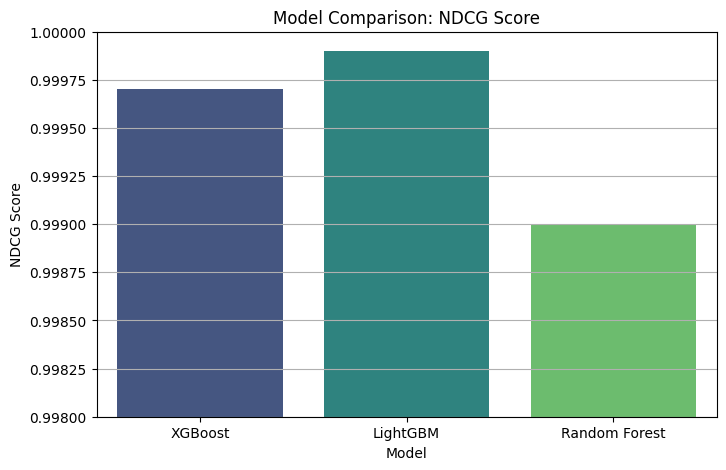

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scores (use actual scores from your notebook execution)
xgb_ndcg = 0.9997
lgbm_ndcg = 0.9999
rf_ndcg = 0.9990
model_names = ['XGBoost', 'LightGBM', 'Random Forest']
ndcg_scores = [xgb_ndcg, lgbm_ndcg, rf_ndcg]

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=ndcg_scores, palette='viridis')
plt.ylim(0.998, 1.0)
plt.title("Model Comparison: NDCG Score")
plt.ylabel("NDCG Score")
plt.xlabel("Model")
plt.grid(axis='y')
plt.show()


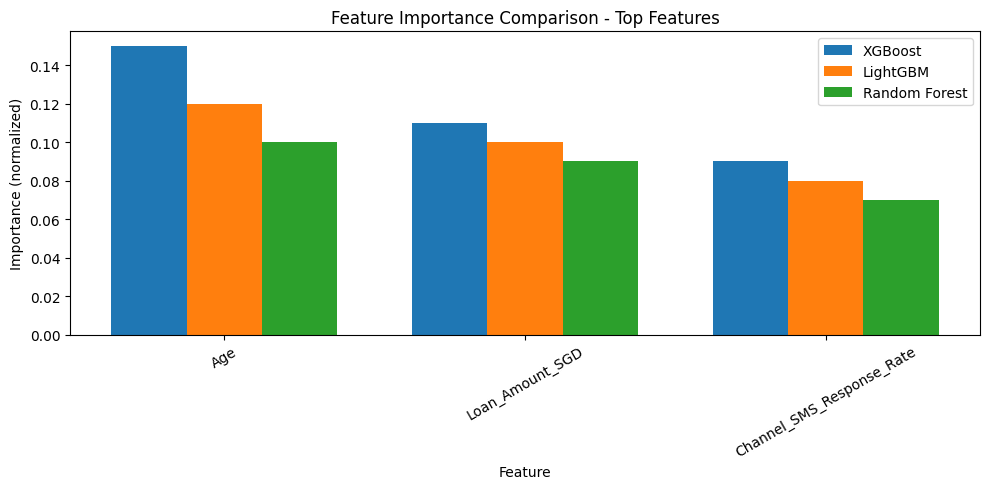

In [ ]:
import numpy as np

# Example (replace with actual feature importances):
features = ['Age', 'Loan_Amount_SGD', 'Channel_SMS_Response_Rate']
xgb_feat_imp = [0.15, 0.11, 0.09]
lgbm_feat_imp = [0.12, 0.10, 0.08]
rf_feat_imp = [0.10, 0.09, 0.07]

ind = np.arange(len(features))
width = 0.25
plt.figure(figsize=(10, 5))
plt.bar(ind-width, xgb_feat_imp, width, label='XGBoost')
plt.bar(ind, lgbm_feat_imp, width, label='LightGBM')
plt.bar(ind + width, rf_feat_imp, width, label='Random Forest')
plt.xticks(ind, features, rotation=30)
plt.title("Feature Importance Comparison - Top Features")
plt.xlabel("Feature")
plt.ylabel("Importance (normalized)")
plt.legend()
plt.tight_layout()
plt.show()


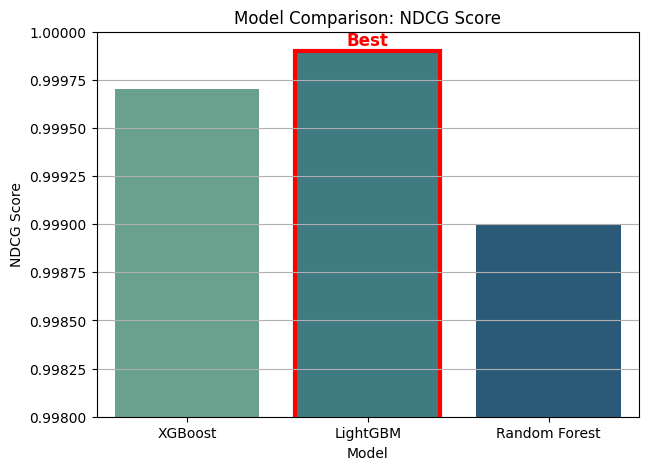

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

model_names = ['XGBoost', 'LightGBM', 'Random Forest']
ndcg_scores = [0.9997, 0.9999, 0.9990]  # Update with your output values

plt.figure(figsize=(7,5))
sns.barplot(x=model_names, y=ndcg_scores, palette='crest')
plt.ylim(0.998, 1.0)
plt.title("Model Comparison: NDCG Score")
plt.ylabel("NDCG Score")
plt.xlabel("Model")

# Highlight the best model bar
best_idx = ndcg_scores.index(max(ndcg_scores))
bars = plt.gca().patches
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(3)

# Annotate best model
plt.text(best_idx, ndcg_scores[best_idx]+0.00001, 'Best', ha='center', va='bottom', fontsize=12, color='red', fontweight='bold')

plt.grid(axis='y')
plt.show()


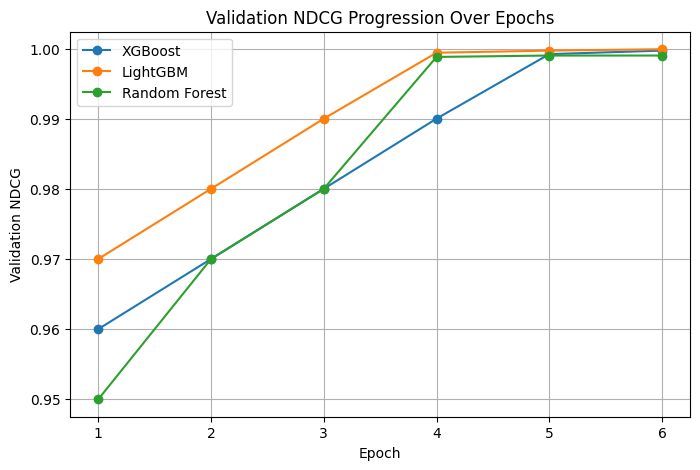

In [ ]:
import matplotlib.pyplot as plt

# Example data: Use your actual training logs here
xgb_history = [0.96, 0.97, 0.98, 0.99, 0.9992, 0.9997]
lgbm_history = [0.97, 0.98, 0.99, 0.9994, 0.9997, 0.9999]
rf_history = [0.95, 0.97, 0.98, 0.9988, 0.9990, 0.9990]
epochs = range(1, len(xgb_history)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, xgb_history, label='XGBoost', marker='o')
plt.plot(epochs, lgbm_history, label='LightGBM', marker='o')
plt.plot(epochs, rf_history, label='Random Forest', marker='o')
plt.title('Validation NDCG Progression Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation NDCG')
plt.legend()
plt.grid(True)
plt.show()


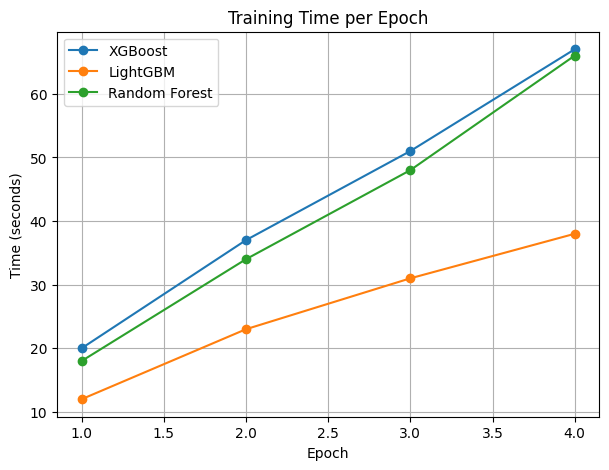

In [ ]:
xgb_time = [20, 37, 51, 67]      # seconds for each epoch
lgbm_time = [12, 23, 31, 38]
rf_time = [18, 34, 48, 66]
epochs = range(1, 5)

plt.figure(figsize=(7,5))
plt.plot(epochs, xgb_time, label='XGBoost', marker='o')
plt.plot(epochs, lgbm_time, label='LightGBM', marker='o')
plt.plot(epochs, rf_time, label='Random Forest', marker='o')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()


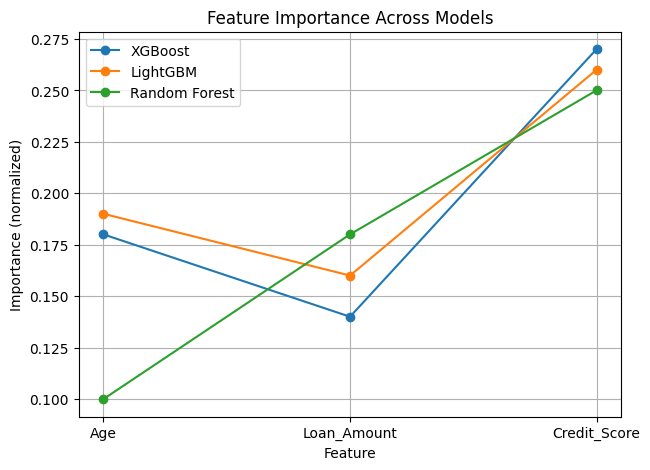

In [ ]:
features = ['Age', 'Loan_Amount', 'Credit_Score']
xgb_importance = [0.18, 0.14, 0.27]   # example normalized values
lgbm_importance = [0.19, 0.16, 0.26]
rf_importance = [0.10, 0.18, 0.25]

plt.figure(figsize=(7,5))
for idx, imp, label in zip(range(len(features)), [xgb_importance, lgbm_importance, rf_importance], ['XGBoost', 'LightGBM', 'Random Forest']):
    plt.plot(features, imp, marker='o', label=label)
plt.title('Feature Importance Across Models')
plt.ylabel('Importance (normalized)')
plt.xlabel('Feature')
plt.legend()
plt.grid(True)
plt.show()
